# Solving the Navier-Stokes equation with tensor-product space-time FEM in FEniCS and mixed order dG($r^v$/$r^p$)-discretization for velocity and pressure

In [1]:
# FEniCS for spatial FEM
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Create temporal basis in SymPy

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Mul, Id, symbols, init_printing, expand, compose, diff, lambdify, Piecewise
from IPython.display import Math, display
from fenics import Mesh, VectorElement, Function, TrialFunction, TestFunction, TestFunctions, FunctionSpace, dx, inner, grad, FiniteElement, MixedElement, Constant, assemble, Expression, interpolate, solve, DirichletBC, plot, errornorm, set_log_active, derivative, parameters, split, dot, div, CompiledSubDomain, MeshFunction, sqrt, Measure, FacetNormal, Identity
from ufl import replace
import time
import pandas as pd

set_log_active(False) # turn off FEniCS logging
parameters["reorder_dofs_serial"] = False

t = symbols("t")
init_printing()

TIME_DG_QUADRATURE = "Gauss-Lobatto"
PROBLEM = "2D-3" #"2D-2"

# HELPER FUNCTIONS
# compute temporal basis functions from the roots
def compute_basis_functions(roots):
    basis = []
    for i in range(len(roots)):
        f = 1 + 0*Id(t)
        for j in range(len(roots)):
            if i != j:
                f = Mul(f,(t - roots[j]) / (roots[i] - roots[j]))
        #basis.append(f)
        basis.append(expand(f))
    return basis

# transform roots from [-1, 1] to [0, 1]
def transform_roots(roots):
    new_roots = []
    for root in roots:
        new_roots.append((root + 1) / 2)
    return new_roots

# dictionary of temporal bases depending on the polynomial degree
# FE basis on reference element (0,1)
φ = {}
roots = {}

roots[0] = [1.]
φ[0] = [1 + 0*Id(t)]
roots[1] = [0., 1.]
φ[1] = [1-t, t]
roots[2] = transform_roots([-1, 0, 1])
φ[2] = compute_basis_functions(roots[2])
#roots[3] = transform_roots([-1, -sqrt(Rational(1,5)), sqrt(Rational(1,5)), 1])
#φ[3] = compute_basis_functions(roots[3])

class TimeFE:
    def __init__(self, r=1, a=0., b=1., n_time=1, n_q_points=3):
        self.r = r # polynomial degree in time
        self.n_time = n_time # number of temporal elements
        self.n_dofs = (self.r+1) * self.n_time # total number of temporal dofs on slab
        self.dof_locations = []
        self.a = a # start time of slab
        self.b = b # end time of slab
        self.k = (self.b - self.a) / self.n_time
        self.epsilon = self.k * 1e-10

        self.generate_mesh()
        self.get_full_basis()
        self.lambdify_basis()
        self.compute_quadrature(n_q_points)

    def generate_mesh(self):
        # create an uniform temporal mesh with mesh size self.k
        self.mesh = [(self.a, self.a+self.k)]
        while len(self.mesh) < self.n_time:
            self.mesh.append((self.mesh[-1][1], self.mesh[-1][1]+self.k))

    # transform basis functions from [0,1] to [a,b]
    def transform_function(self, f, a, b):
        return compose(f, (t-a)/(b-a)) # = f((t-a)/(b-a))
    
    def transform_derivative(self, a, b):
        return 1 / (b-a)

    # get full FE basis and its derivative on temporal mesh
    def get_full_basis(self):
        self._basis = []
        self._basis_derivative = []
        self.local_dofs = {}
        i = 0
        for (a,b) in self.mesh:
            self.local_dofs[(a,b)] = []
            for f, t_q in zip(φ[self.r], roots[self.r]):
                self._basis.append(self.transform_function(f, a, b))
                self._basis_derivative.append(diff(self._basis[-1],t))
                #print(diff(self._basis[-1],t))
                #print(self.transform_function(diff(f,t), a, b) * self.transform_derivative(a, b))
                self.local_dofs[(a,b)].append(i)
                self.dof_locations.append(t_q*(b-a)+a)
                i += 1

    # convert SymPy functions to Python functions and ensure that they are 0 outside the element that they are defined on
    def lambdify_basis(self):
        self.phi = []
        self.dt_phi = []

        for (a,b) in self.mesh:
            for i in self.local_dofs[(a,b)]:
                self.phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis[i], True)
                        )
                    )
                )

                self.dt_phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis_derivative[i], True)
                        )
                    )
                )

    def compute_quadrature(self, n_q_points):
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]
            
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points+2)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature_fine = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature_fine[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]

    def plot_basis(self, basis_type="function", title=None):
        assert basis_type in ["function", "derivative"], f"basis_type='{basis_type}' has not been implemented."

        _t = np.linspace(self.a, self.b, 100)
        for i in range(len(self.phi)):
            if basis_type == "function":
                plt.plot(_t, [self.phi[i](time_point) for time_point in _t], label=rf"$\varphi_{{{i}}}$")
            elif basis_type == "derivative":
                plt.plot(_t, [self.dt_phi[i](time_point) for time_point in _t], label=rf"$\partial_t \varphi_{{{i}}}$")

        plt.xlabel("t")
        plt.ylabel("f(t)")
        plt.legend()
        if title is not None:
            plt.title(title)
        plt.show()
        
    def get_solution_at_time(self, time_point, U):
        tmp = np.zeros_like(U[0])
        for i in range(self.n_dofs):
            tmp += self.phi[i](time_point) * U[i]
        return tmp

## Assemble space-time integrals using numerical quadrature in time and FEniCS forms in space

CONFIG: problem = 2D-3, s = (2/1), r = (1/0) (Gauss-Lobatto), slab_size = 0.030625, n_x = 1


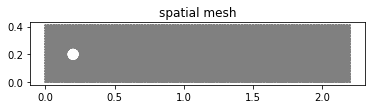

Number of spatial DoFs: 27720 (24574 + 3146)
Solving on slab_0 = Ω x (0.0, 0.03062) ...
Spaces = [v,v,p,]
t = 0.030625:


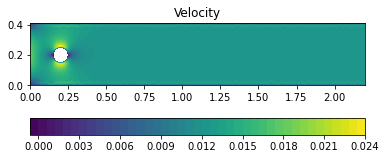

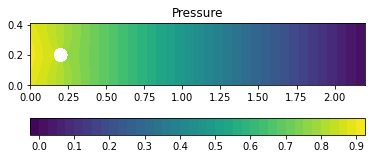

Done.

Solving on slab_1 = Ω x (0.03062, 0.06125) ...
Spaces = [v,v,p,]
t = 0.06125:


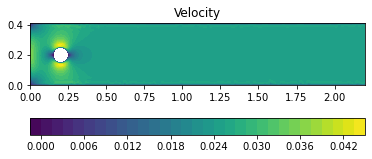

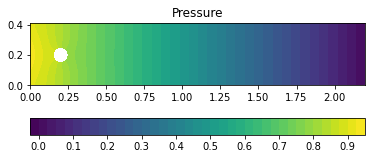

Done.

Solving on slab_2 = Ω x (0.06125, 0.09187) ...
Spaces = [v,v,p,]
t = 0.091875:


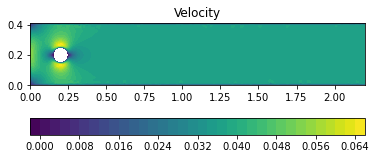

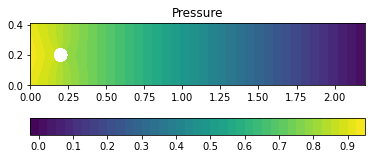

Done.

Solving on slab_3 = Ω x (0.09187, 0.1225) ...
Spaces = [v,v,p,]
t = 0.1225:


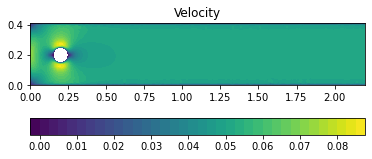

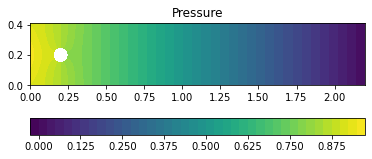

Done.

Solving on slab_4 = Ω x (0.1225, 0.15313) ...
Spaces = [v,v,p,]
t = 0.153125:


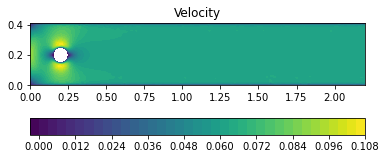

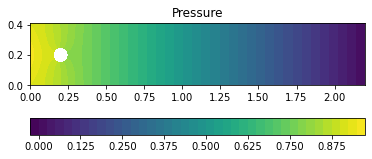

Done.

Solving on slab_5 = Ω x (0.15313, 0.18375) ...
Spaces = [v,v,p,]
t = 0.18375000000000002:


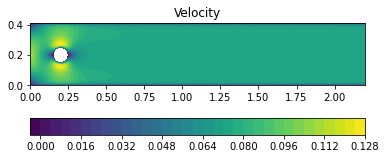

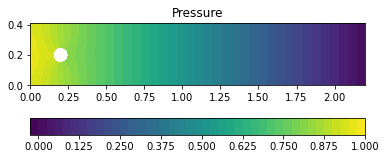

Done.

Solving on slab_6 = Ω x (0.18375, 0.21438) ...
Spaces = [v,v,p,]
t = 0.21437500000000004:


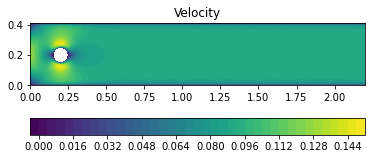

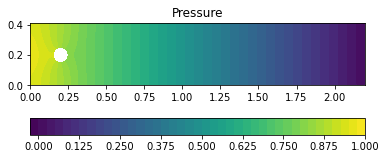

Done.

Solving on slab_7 = Ω x (0.21438, 0.245) ...
Spaces = [v,v,p,]
t = 0.24500000000000005:


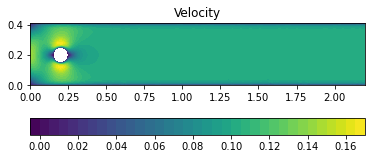

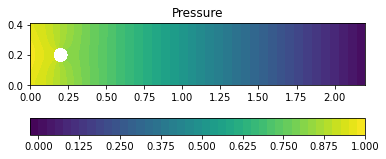

Done.

Solving on slab_8 = Ω x (0.245, 0.27563) ...
Spaces = [v,v,p,]
t = 0.27562500000000006:


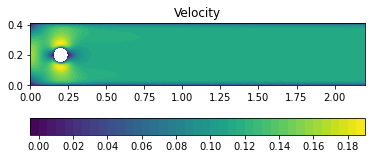

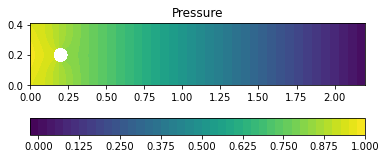

Done.

Solving on slab_9 = Ω x (0.27563, 0.30625) ...
Spaces = [v,v,p,]
t = 0.3062500000000001:


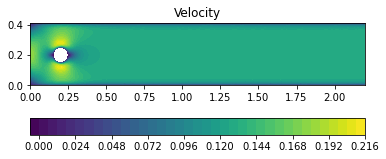

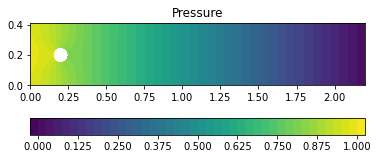

Done.

Solving on slab_10 = Ω x (0.30625, 0.33688) ...
Spaces = [v,v,p,]
t = 0.3368750000000001:


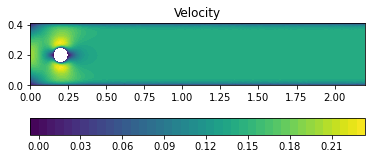

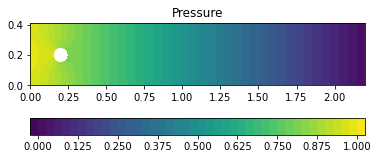

Done.

Solving on slab_11 = Ω x (0.33688, 0.3675) ...
Spaces = [v,v,p,]
t = 0.3675000000000001:


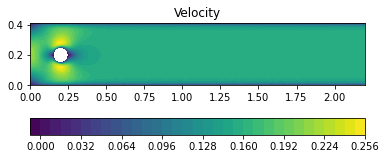

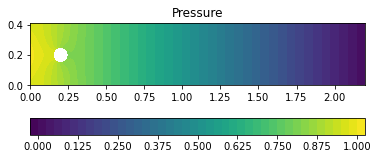

Done.

Solving on slab_12 = Ω x (0.3675, 0.39813) ...
Spaces = [v,v,p,]
t = 0.3981250000000001:


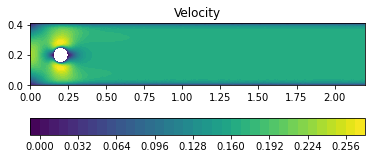

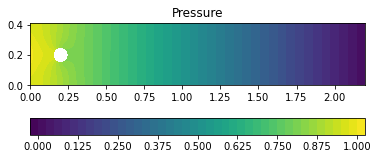

Done.

Solving on slab_13 = Ω x (0.39813, 0.42875) ...
Spaces = [v,v,p,]
t = 0.42875000000000013:


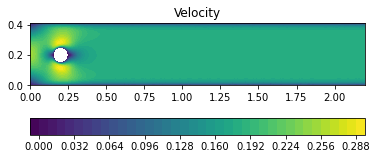

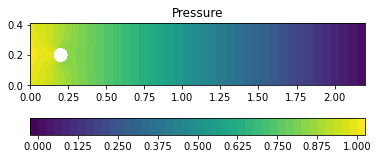

Done.

Solving on slab_14 = Ω x (0.42875, 0.45938) ...
Spaces = [v,v,p,]
t = 0.45937500000000014:


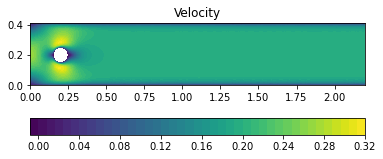

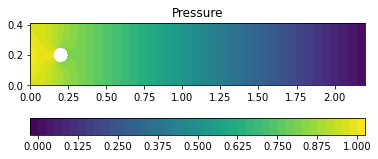

Done.

Solving on slab_15 = Ω x (0.45938, 0.49) ...
Spaces = [v,v,p,]
t = 0.49000000000000016:


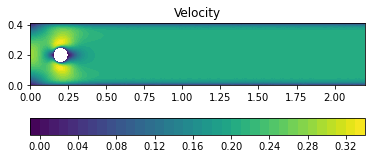

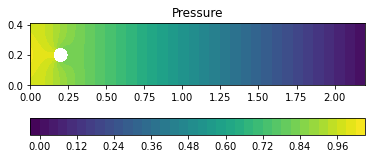

Done.

Solving on slab_16 = Ω x (0.49, 0.52063) ...
Spaces = [v,v,p,]
t = 0.5206250000000001:


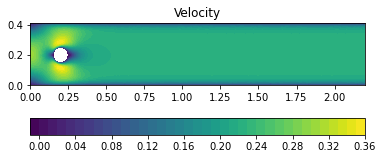

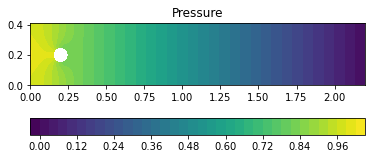

Done.

Solving on slab_17 = Ω x (0.52063, 0.55125) ...
Spaces = [v,v,p,]
t = 0.5512500000000001:


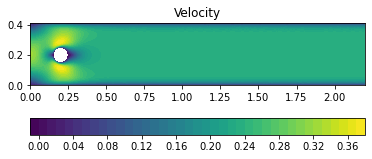

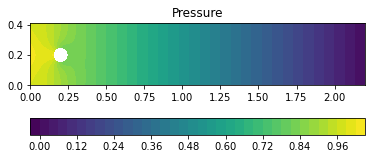

Done.

Solving on slab_18 = Ω x (0.55125, 0.58188) ...
Spaces = [v,v,p,]
t = 0.5818750000000001:


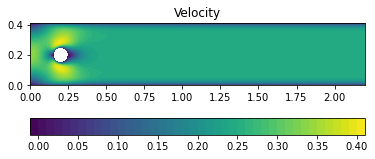

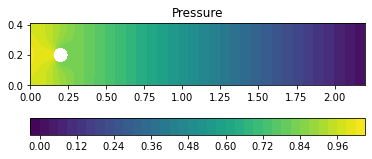

Done.

Solving on slab_19 = Ω x (0.58188, 0.6125) ...
Spaces = [v,v,p,]
t = 0.6125000000000002:


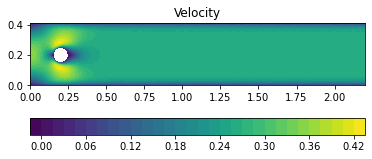

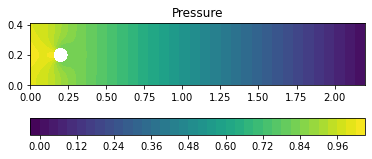

Done.

Solving on slab_20 = Ω x (0.6125, 0.64313) ...
Spaces = [v,v,p,]
t = 0.6431250000000002:


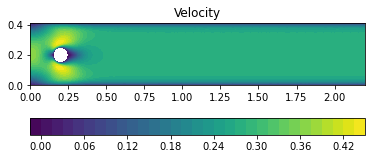

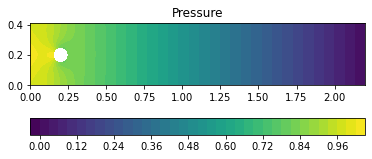

Done.

Solving on slab_21 = Ω x (0.64313, 0.67375) ...
Spaces = [v,v,p,]
t = 0.6737500000000002:


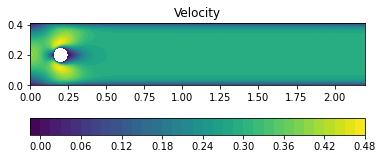

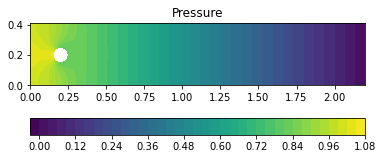

Done.

Solving on slab_22 = Ω x (0.67375, 0.70438) ...
Spaces = [v,v,p,]
t = 0.7043750000000002:


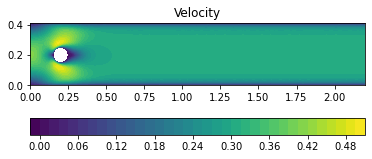

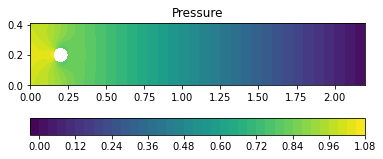

Done.

Solving on slab_23 = Ω x (0.70438, 0.735) ...
Spaces = [v,v,p,]
t = 0.7350000000000002:


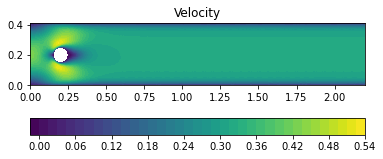

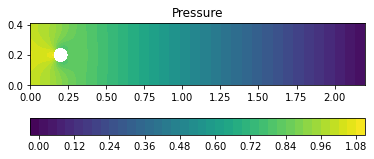

Done.

Solving on slab_24 = Ω x (0.735, 0.76563) ...
Spaces = [v,v,p,]
t = 0.7656250000000002:


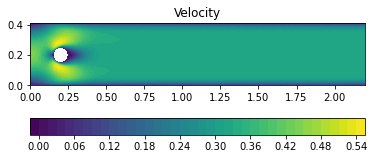

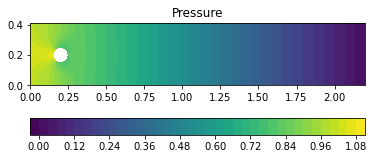

Done.

Solving on slab_25 = Ω x (0.76563, 0.79625) ...
Spaces = [v,v,p,]
t = 0.7962500000000002:


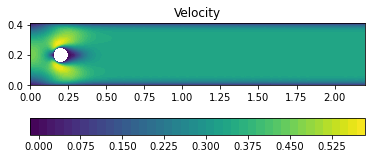

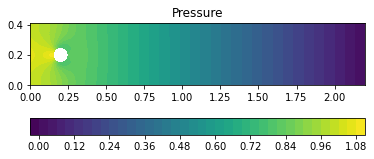

Done.

Solving on slab_26 = Ω x (0.79625, 0.82688) ...
Spaces = [v,v,p,]
t = 0.8268750000000002:


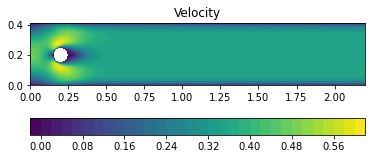

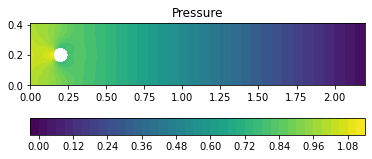

Done.

Solving on slab_27 = Ω x (0.82688, 0.8575) ...
Spaces = [v,v,p,]
t = 0.8575000000000003:


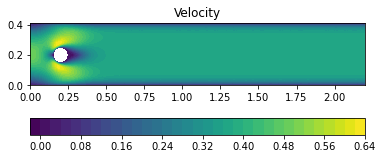

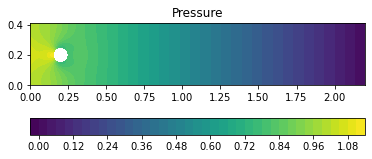

Done.

Solving on slab_28 = Ω x (0.8575, 0.88813) ...
Spaces = [v,v,p,]
t = 0.8881250000000003:


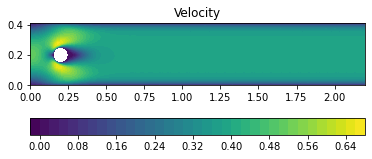

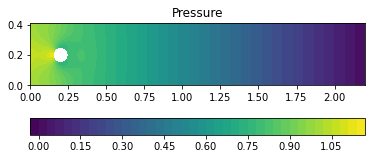

Done.

Solving on slab_29 = Ω x (0.88813, 0.91875) ...
Spaces = [v,v,p,]
t = 0.9187500000000003:


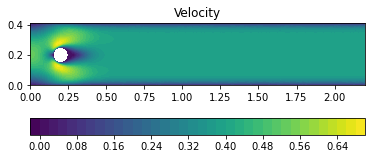

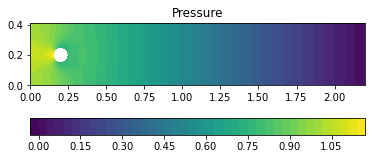

Done.

Solving on slab_30 = Ω x (0.91875, 0.94938) ...
Spaces = [v,v,p,]
t = 0.9493750000000003:


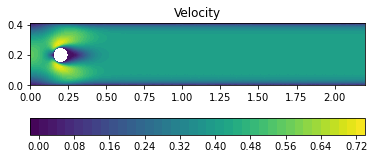

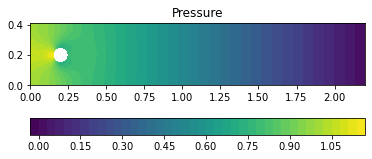

Done.

Solving on slab_31 = Ω x (0.94938, 0.98) ...
Spaces = [v,v,p,]
t = 0.9800000000000003:


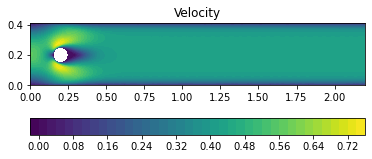

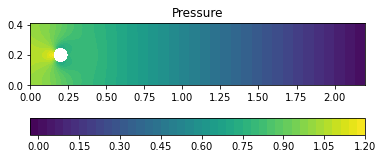

Done.

Solving on slab_32 = Ω x (0.98, 1.01063) ...
Spaces = [v,v,p,]
t = 1.0106250000000003:


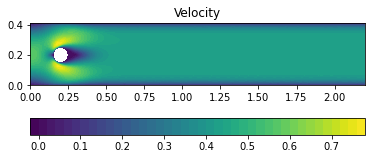

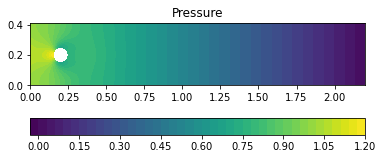

Done.

Solving on slab_33 = Ω x (1.01063, 1.04125) ...
Spaces = [v,v,p,]
t = 1.0412500000000002:


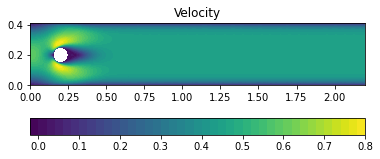

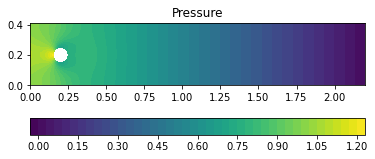

Done.

Solving on slab_34 = Ω x (1.04125, 1.07188) ...
Spaces = [v,v,p,]
t = 1.0718750000000001:


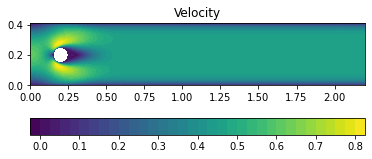

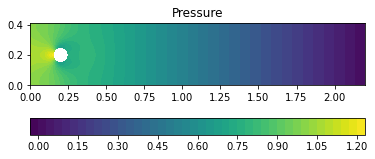

Done.

Solving on slab_35 = Ω x (1.07188, 1.1025) ...
Spaces = [v,v,p,]
t = 1.1025:


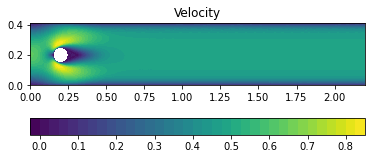

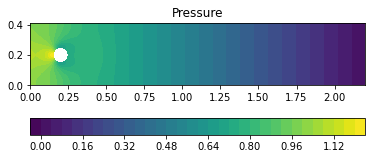

Done.

Solving on slab_36 = Ω x (1.1025, 1.13312) ...
Spaces = [v,v,p,]
t = 1.133125:


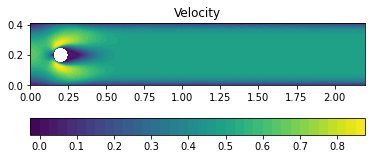

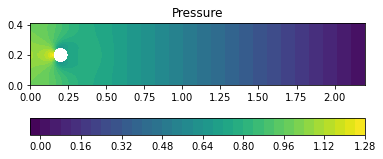

Done.

Solving on slab_37 = Ω x (1.13312, 1.16375) ...
Spaces = [v,v,p,]
t = 1.1637499999999998:


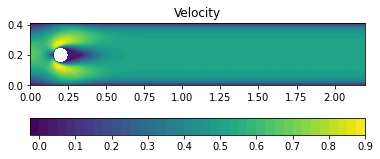

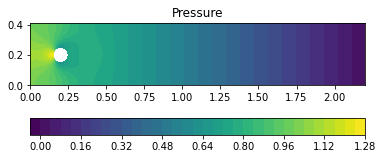

Done.

Solving on slab_38 = Ω x (1.16375, 1.19437) ...
Spaces = [v,v,p,]
t = 1.1943749999999997:


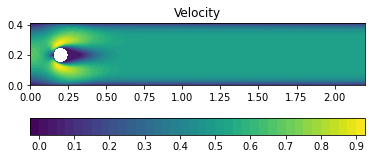

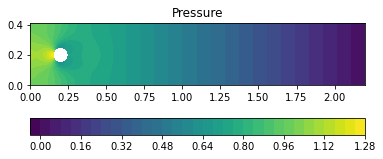

Done.

Solving on slab_39 = Ω x (1.19437, 1.225) ...
Spaces = [v,v,p,]
t = 1.2249999999999996:


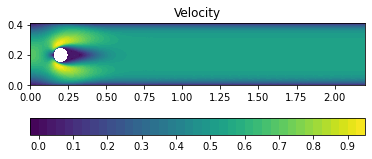

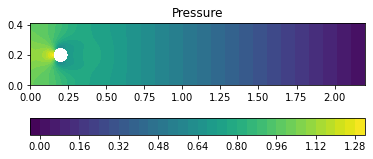

Done.

Solving on slab_40 = Ω x (1.225, 1.25562) ...
Spaces = [v,v,p,]
t = 1.2556249999999995:


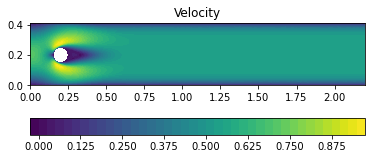

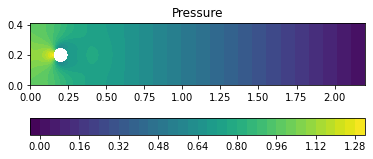

Done.

Solving on slab_41 = Ω x (1.25562, 1.28625) ...
Spaces = [v,v,p,]
t = 1.2862499999999994:


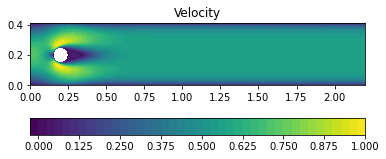

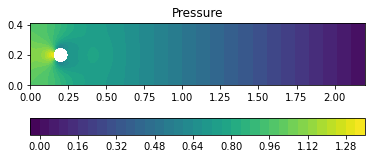

Done.

Solving on slab_42 = Ω x (1.28625, 1.31687) ...
Spaces = [v,v,p,]
t = 1.3168749999999994:


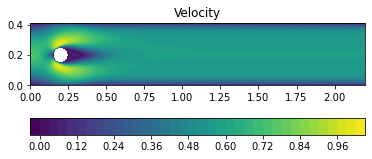

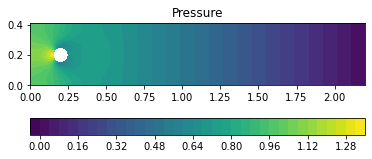

Done.

Solving on slab_43 = Ω x (1.31687, 1.3475) ...
Spaces = [v,v,p,]
t = 1.3474999999999993:


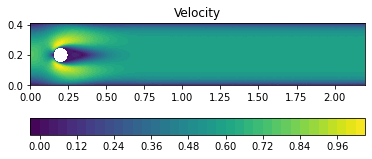

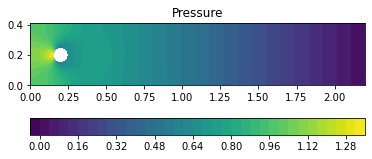

Done.

Solving on slab_44 = Ω x (1.3475, 1.37812) ...
Spaces = [v,v,p,]
t = 1.3781249999999992:


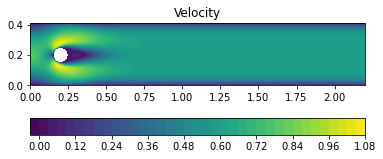

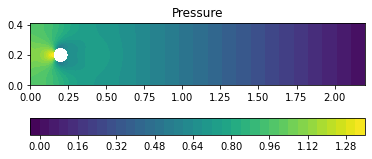

Done.

Solving on slab_45 = Ω x (1.37812, 1.40875) ...
Spaces = [v,v,p,]
t = 1.408749999999999:


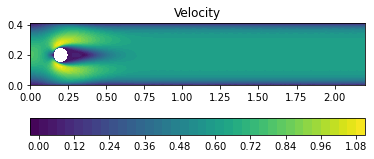

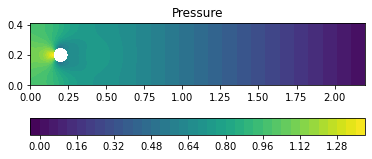

Done.

Solving on slab_46 = Ω x (1.40875, 1.43937) ...
Spaces = [v,v,p,]
t = 1.439374999999999:


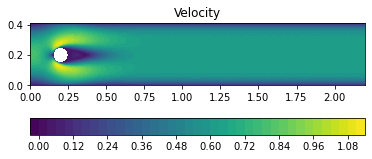

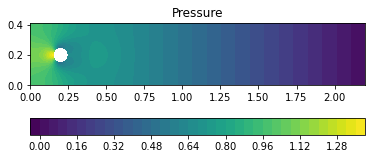

Done.

Solving on slab_47 = Ω x (1.43937, 1.47) ...
Spaces = [v,v,p,]
t = 1.4699999999999989:


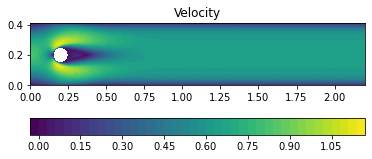

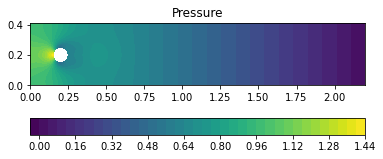

Done.

Solving on slab_48 = Ω x (1.47, 1.50062) ...
Spaces = [v,v,p,]
t = 1.5006249999999988:


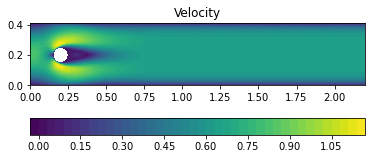

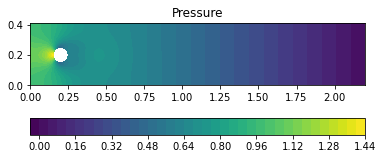

Done.

Solving on slab_49 = Ω x (1.50062, 1.53125) ...
Spaces = [v,v,p,]
t = 1.5312499999999987:


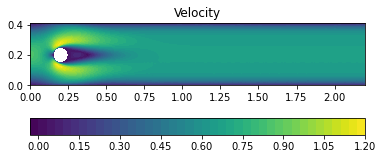

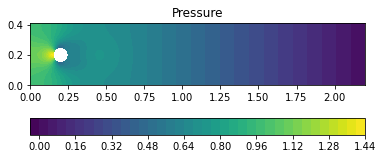

Done.

Solving on slab_50 = Ω x (1.53125, 1.56187) ...
Spaces = [v,v,p,]
t = 1.5618749999999986:


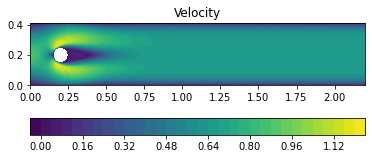

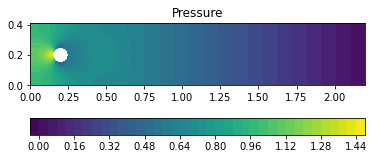

Done.

Solving on slab_51 = Ω x (1.56187, 1.5925) ...
Spaces = [v,v,p,]
t = 1.5924999999999985:


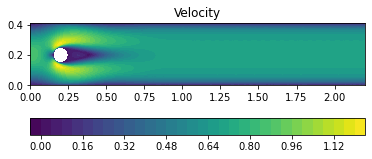

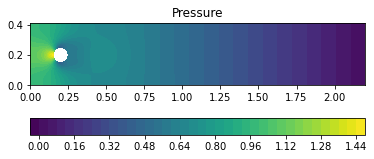

Done.

Solving on slab_52 = Ω x (1.5925, 1.62312) ...
Spaces = [v,v,p,]
t = 1.6231249999999984:


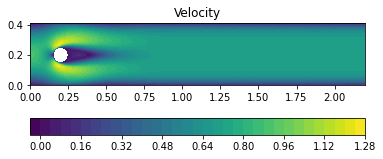

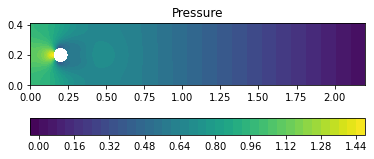

Done.

Solving on slab_53 = Ω x (1.62312, 1.65375) ...
Spaces = [v,v,p,]
t = 1.6537499999999983:


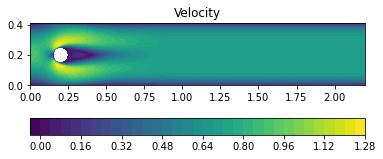

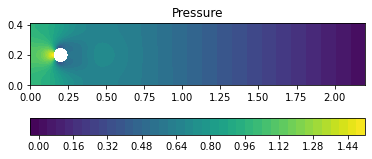

Done.

Solving on slab_54 = Ω x (1.65375, 1.68437) ...
Spaces = [v,v,p,]
t = 1.6843749999999982:


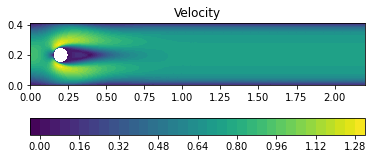

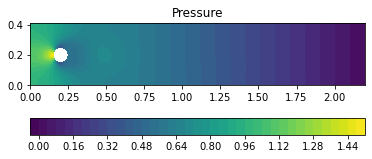

Done.

Solving on slab_55 = Ω x (1.68437, 1.715) ...
Spaces = [v,v,p,]
t = 1.714999999999998:


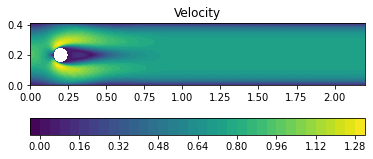

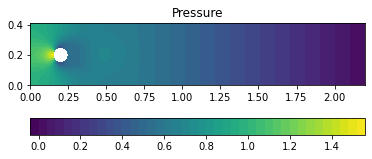

Done.

Solving on slab_56 = Ω x (1.715, 1.74562) ...
Spaces = [v,v,p,]
t = 1.745624999999998:


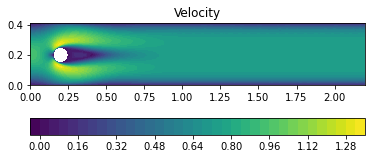

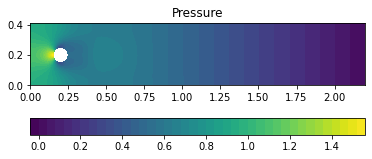

Done.

Solving on slab_57 = Ω x (1.74562, 1.77625) ...
Spaces = [v,v,p,]
t = 1.7762499999999979:


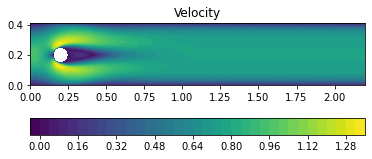

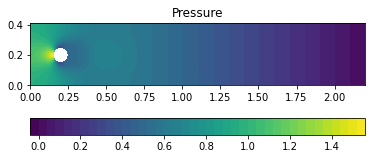

Done.

Solving on slab_58 = Ω x (1.77625, 1.80687) ...
Spaces = [v,v,p,]
t = 1.8068749999999978:


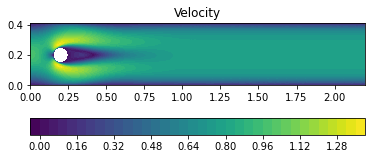

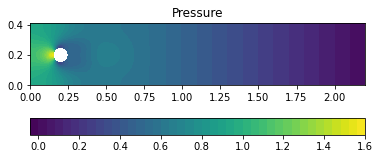

Done.

Solving on slab_59 = Ω x (1.80687, 1.8375) ...
Spaces = [v,v,p,]
t = 1.8374999999999977:


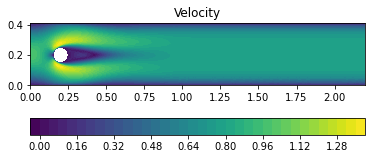

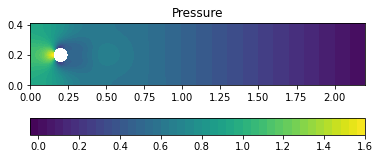

Done.

Solving on slab_60 = Ω x (1.8375, 1.86812) ...
Spaces = [v,v,p,]
t = 1.8681249999999976:


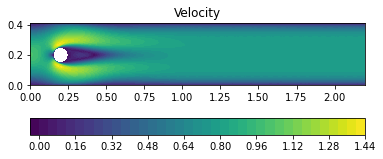

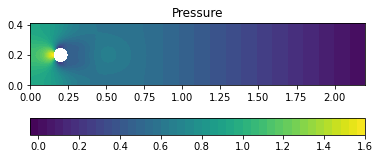

Done.

Solving on slab_61 = Ω x (1.86812, 1.89875) ...
Spaces = [v,v,p,]
t = 1.8987499999999975:


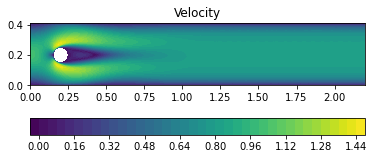

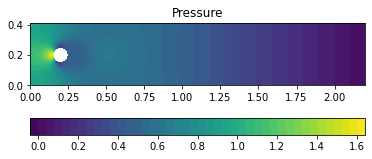

Done.

Solving on slab_62 = Ω x (1.89875, 1.92937) ...
Spaces = [v,v,p,]
t = 1.9293749999999974:


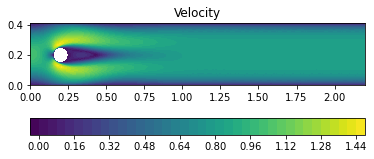

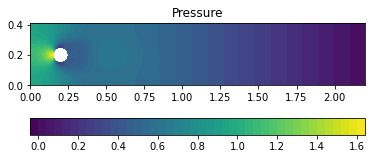

Done.

Solving on slab_63 = Ω x (1.92937, 1.96) ...
Spaces = [v,v,p,]
t = 1.9599999999999973:


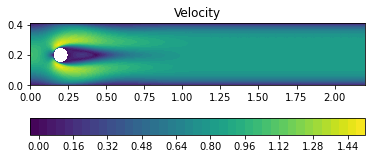

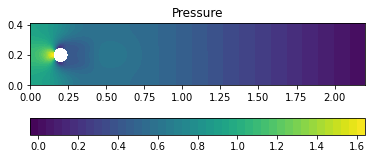

Done.

Solving on slab_64 = Ω x (1.96, 1.99062) ...
Spaces = [v,v,p,]
t = 1.9906249999999972:


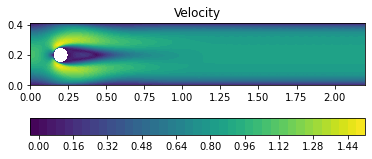

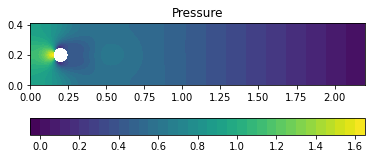

Done.

Solving on slab_65 = Ω x (1.99062, 2.02125) ...
Spaces = [v,v,p,]
t = 2.021249999999997:


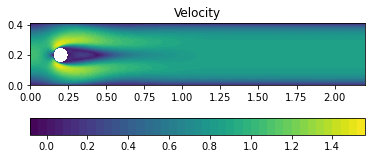

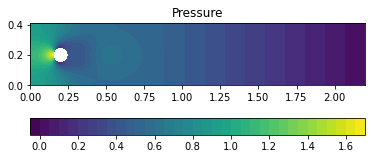

Done.

Solving on slab_66 = Ω x (2.02125, 2.05187) ...
Spaces = [v,v,p,]
t = 2.0518749999999972:


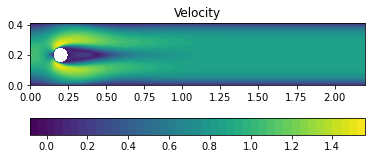

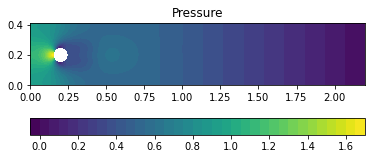

Done.

Solving on slab_67 = Ω x (2.05187, 2.0825) ...
Spaces = [v,v,p,]
t = 2.0824999999999974:


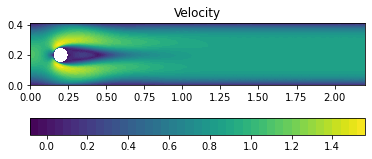

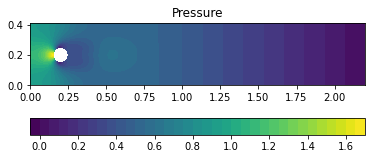

Done.

Solving on slab_68 = Ω x (2.0825, 2.11312) ...
Spaces = [v,v,p,]
t = 2.1131249999999975:


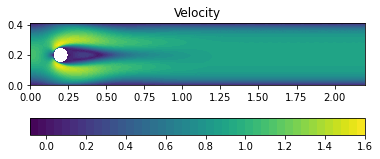

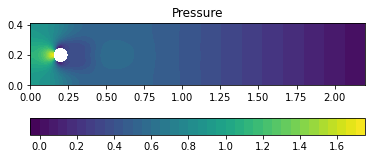

Done.

Solving on slab_69 = Ω x (2.11312, 2.14375) ...
Spaces = [v,v,p,]
t = 2.1437499999999976:


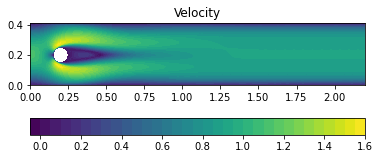

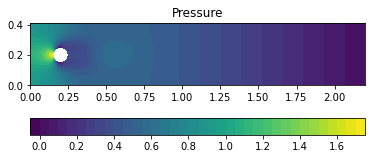

Done.

Solving on slab_70 = Ω x (2.14375, 2.17437) ...
Spaces = [v,v,p,]
t = 2.1743749999999977:


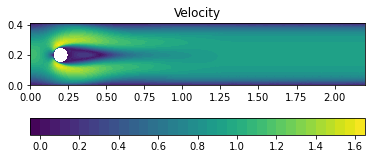

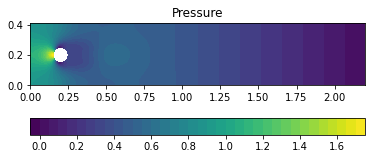

Done.

Solving on slab_71 = Ω x (2.17437, 2.205) ...
Spaces = [v,v,p,]
t = 2.204999999999998:


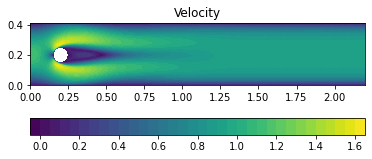

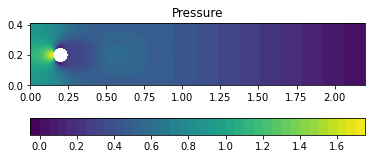

Done.

Solving on slab_72 = Ω x (2.205, 2.23562) ...
Spaces = [v,v,p,]
t = 2.235624999999998:


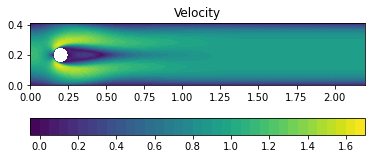

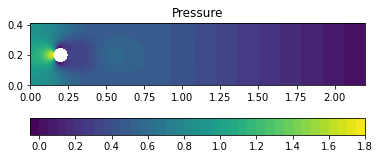

Done.

Solving on slab_73 = Ω x (2.23562, 2.26625) ...
Spaces = [v,v,p,]
t = 2.266249999999998:


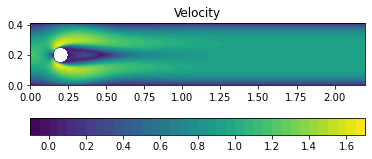

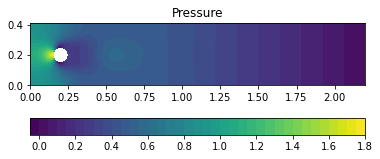

Done.

Solving on slab_74 = Ω x (2.26625, 2.29687) ...
Spaces = [v,v,p,]
t = 2.2968749999999982:


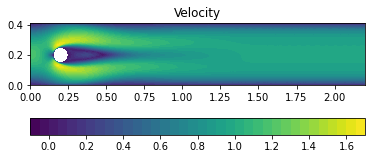

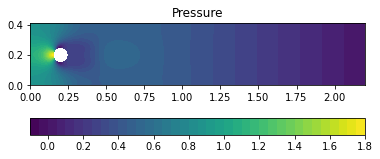

Done.

Solving on slab_75 = Ω x (2.29687, 2.3275) ...
Spaces = [v,v,p,]
t = 2.3274999999999983:


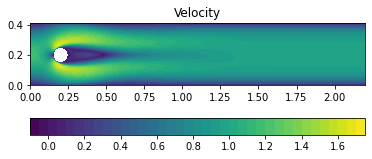

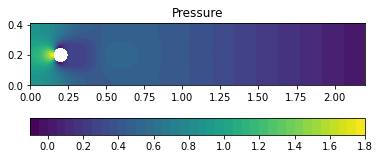

Done.

Solving on slab_76 = Ω x (2.3275, 2.35812) ...
Spaces = [v,v,p,]
t = 2.3581249999999985:


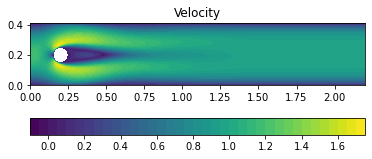

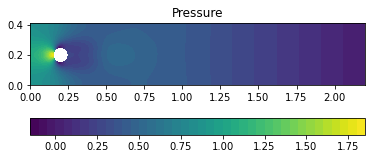

Done.

Solving on slab_77 = Ω x (2.35812, 2.38875) ...
Spaces = [v,v,p,]
t = 2.3887499999999986:


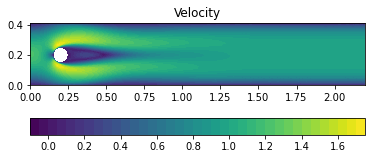

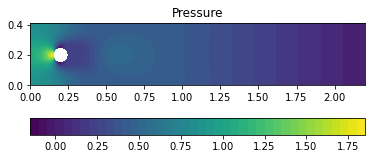

Done.

Solving on slab_78 = Ω x (2.38875, 2.41937) ...
Spaces = [v,v,p,]
t = 2.4193749999999987:


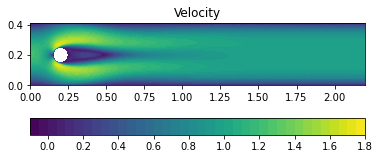

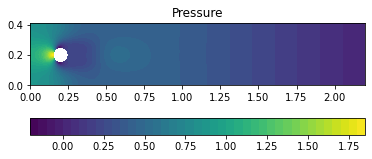

Done.

Solving on slab_79 = Ω x (2.41937, 2.45) ...
Spaces = [v,v,p,]
t = 2.449999999999999:


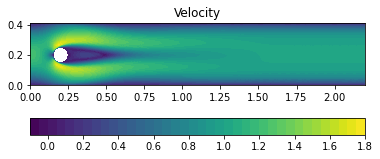

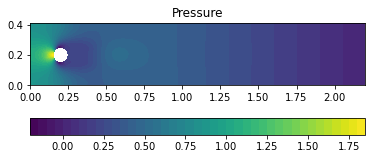

Done.

Solving on slab_80 = Ω x (2.45, 2.48062) ...
Spaces = [v,v,p,]
t = 2.480624999999999:


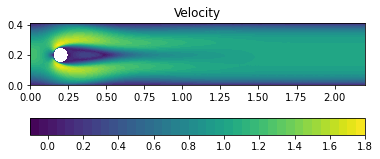

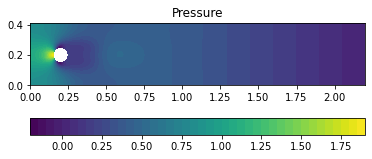

Done.

Solving on slab_81 = Ω x (2.48062, 2.51125) ...
Spaces = [v,v,p,]
t = 2.511249999999999:


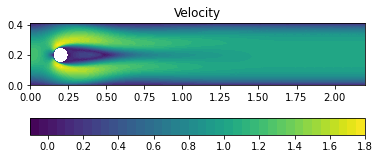

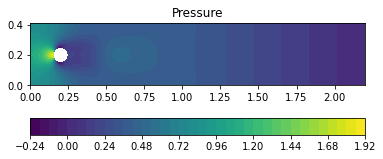

Done.

Solving on slab_82 = Ω x (2.51125, 2.54187) ...
Spaces = [v,v,p,]
t = 2.541874999999999:


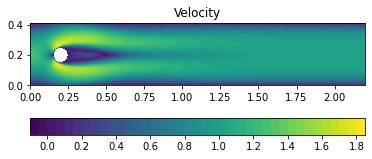

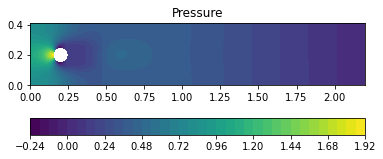

Done.

Solving on slab_83 = Ω x (2.54187, 2.5725) ...
Spaces = [v,v,p,]
t = 2.5724999999999993:


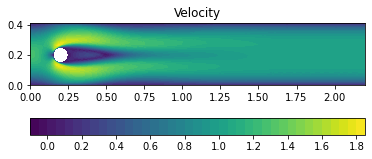

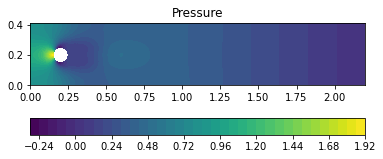

Done.

Solving on slab_84 = Ω x (2.5725, 2.60312) ...
Spaces = [v,v,p,]
t = 2.6031249999999995:


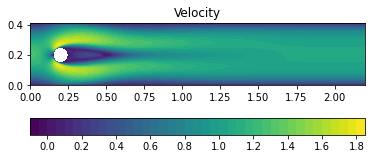

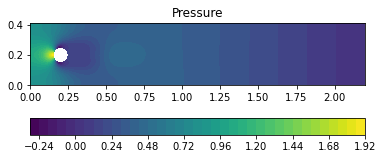

Done.

Solving on slab_85 = Ω x (2.60312, 2.63375) ...
Spaces = [v,v,p,]
t = 2.6337499999999996:


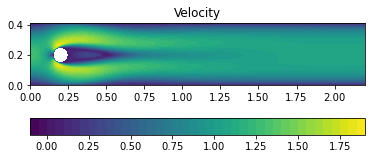

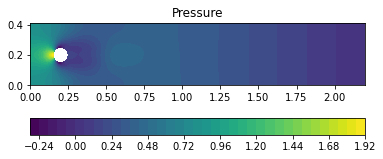

Done.

Solving on slab_86 = Ω x (2.63375, 2.66437) ...
Spaces = [v,v,p,]
t = 2.6643749999999997:


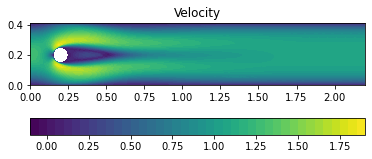

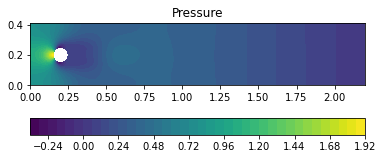

Done.

Solving on slab_87 = Ω x (2.66437, 2.695) ...
Spaces = [v,v,p,]
t = 2.695:


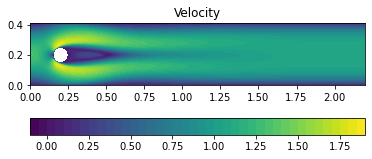

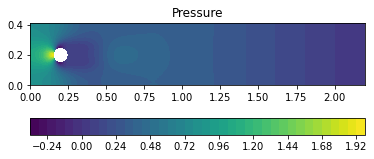

Done.

Solving on slab_88 = Ω x (2.695, 2.72562) ...
Spaces = [v,v,p,]
t = 2.725625:


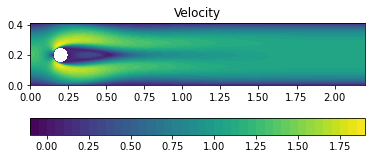

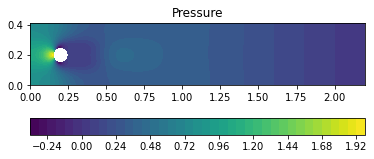

Done.

Solving on slab_89 = Ω x (2.72562, 2.75625) ...
Spaces = [v,v,p,]
t = 2.75625:


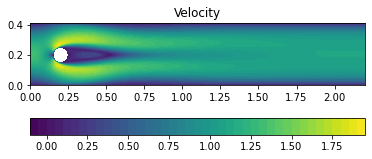

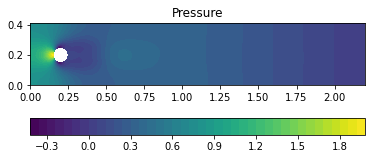

Done.

Solving on slab_90 = Ω x (2.75625, 2.78688) ...
Spaces = [v,v,p,]
t = 2.786875:


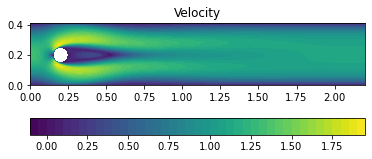

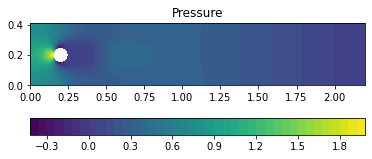

Done.

Solving on slab_91 = Ω x (2.78688, 2.8175) ...
Spaces = [v,v,p,]
t = 2.8175000000000003:


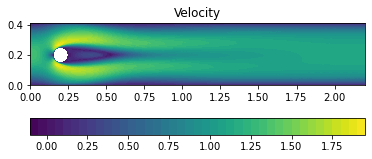

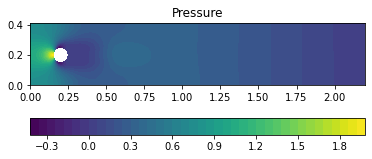

Done.

Solving on slab_92 = Ω x (2.8175, 2.84813) ...
Spaces = [v,v,p,]
t = 2.8481250000000005:


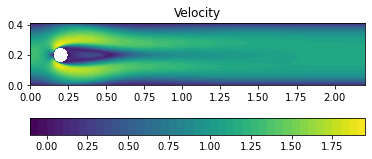

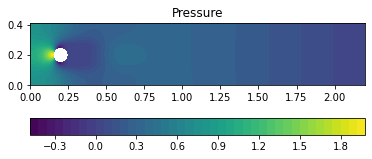

Done.

Solving on slab_93 = Ω x (2.84813, 2.87875) ...
Spaces = [v,v,p,]
t = 2.8787500000000006:


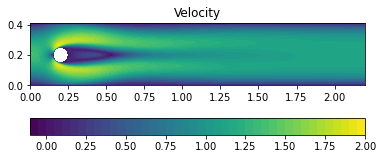

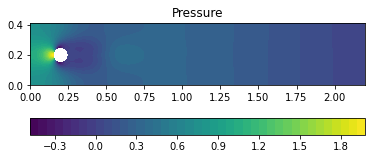

Done.

Solving on slab_94 = Ω x (2.87875, 2.90938) ...
Spaces = [v,v,p,]
t = 2.9093750000000007:


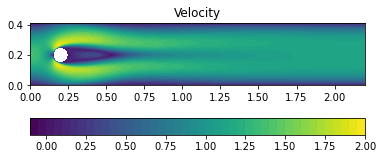

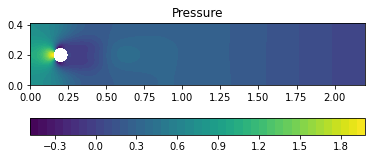

Done.

Solving on slab_95 = Ω x (2.90938, 2.94) ...
Spaces = [v,v,p,]
t = 2.940000000000001:


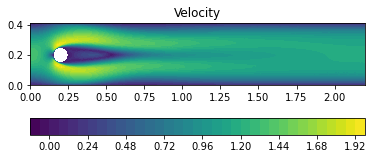

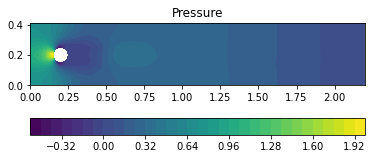

Done.

Solving on slab_96 = Ω x (2.94, 2.97063) ...
Spaces = [v,v,p,]
t = 2.970625000000001:


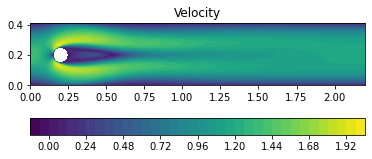

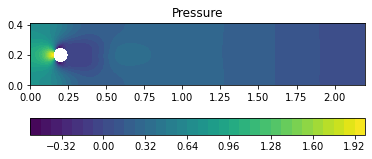

Done.

Solving on slab_97 = Ω x (2.97063, 3.00125) ...
Spaces = [v,v,p,]
t = 3.001250000000001:


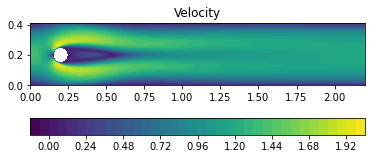

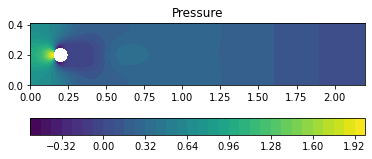

Done.

Solving on slab_98 = Ω x (3.00125, 3.03188) ...
Spaces = [v,v,p,]
t = 3.031875000000001:


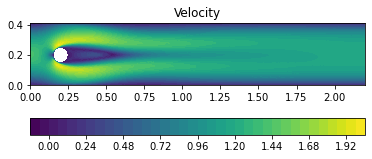

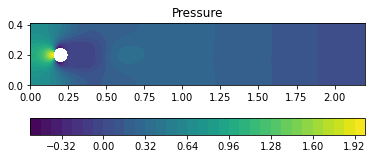

Done.

Solving on slab_99 = Ω x (3.03188, 3.0625) ...
Spaces = [v,v,p,]
t = 3.0625000000000013:


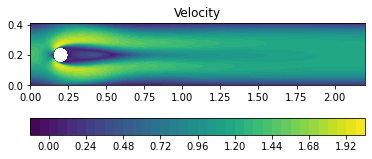

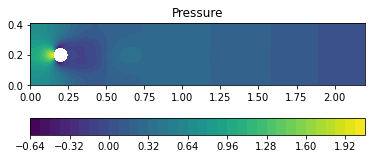

Done.

Solving on slab_100 = Ω x (3.0625, 3.09313) ...
Spaces = [v,v,p,]
t = 3.0931250000000015:


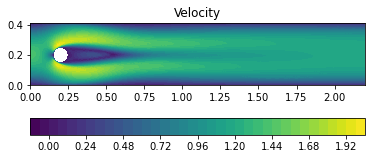

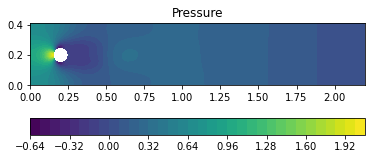

Done.

Solving on slab_101 = Ω x (3.09313, 3.12375) ...
Spaces = [v,v,p,]
t = 3.1237500000000016:


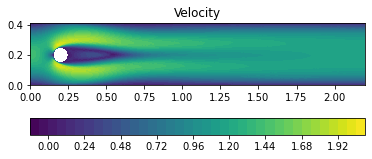

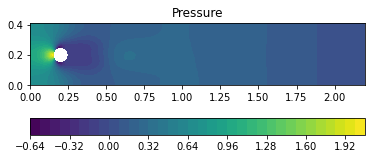

Done.

Solving on slab_102 = Ω x (3.12375, 3.15438) ...
Spaces = [v,v,p,]
t = 3.1543750000000017:


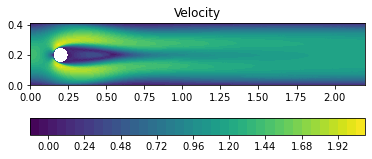

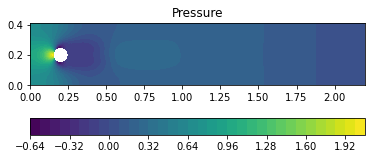

Done.

Solving on slab_103 = Ω x (3.15438, 3.185) ...
Spaces = [v,v,p,]
t = 3.185000000000002:


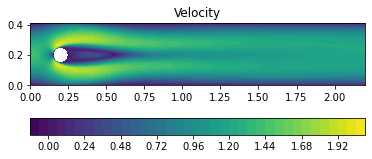

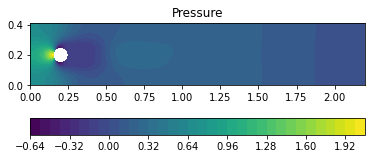

Done.

Solving on slab_104 = Ω x (3.185, 3.21563) ...
Spaces = [v,v,p,]
t = 3.215625000000002:


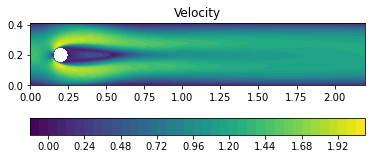

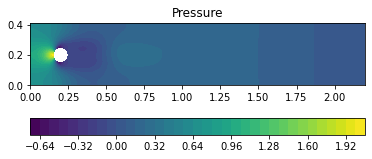

Done.

Solving on slab_105 = Ω x (3.21563, 3.24625) ...
Spaces = [v,v,p,]
t = 3.246250000000002:


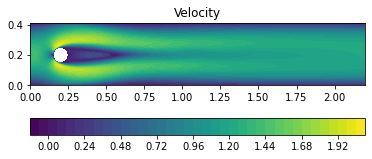

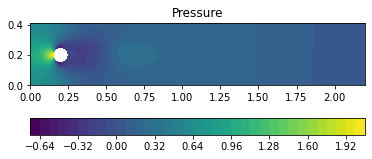

Done.

Solving on slab_106 = Ω x (3.24625, 3.27688) ...
Spaces = [v,v,p,]
t = 3.276875000000002:


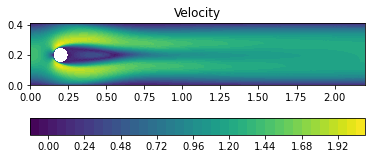

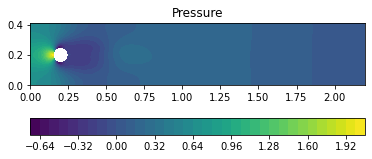

Done.

Solving on slab_107 = Ω x (3.27688, 3.3075) ...
Spaces = [v,v,p,]
t = 3.3075000000000023:


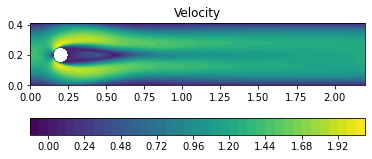

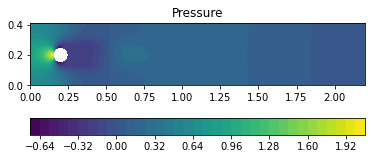

Done.

Solving on slab_108 = Ω x (3.3075, 3.33813) ...
Spaces = [v,v,p,]
t = 3.3381250000000025:


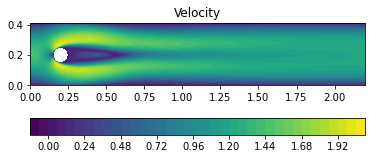

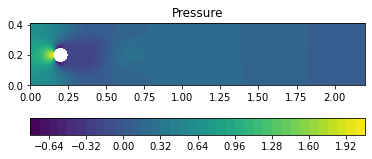

Done.

Solving on slab_109 = Ω x (3.33813, 3.36875) ...
Spaces = [v,v,p,]
t = 3.3687500000000026:


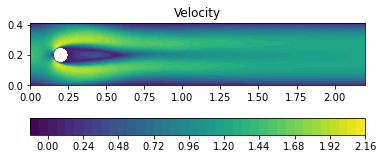

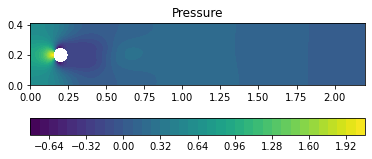

Done.

Solving on slab_110 = Ω x (3.36875, 3.39938) ...
Spaces = [v,v,p,]
t = 3.3993750000000027:


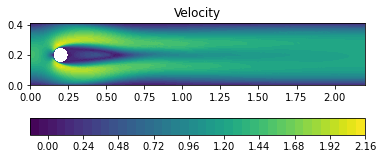

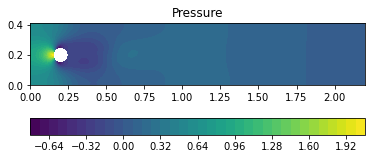

Done.

Solving on slab_111 = Ω x (3.39938, 3.43) ...
Spaces = [v,v,p,]
t = 3.430000000000003:


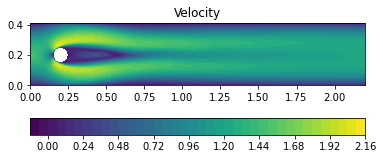

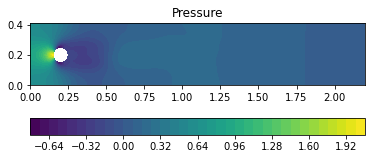

Done.

Solving on slab_112 = Ω x (3.43, 3.46063) ...
Spaces = [v,v,p,]
t = 3.460625000000003:


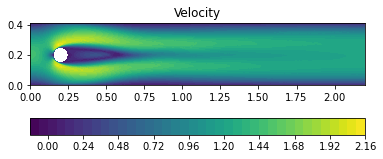

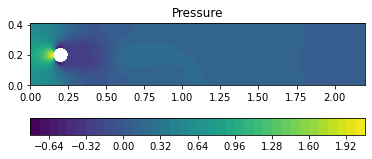

Done.

Solving on slab_113 = Ω x (3.46063, 3.49125) ...
Spaces = [v,v,p,]
t = 3.491250000000003:


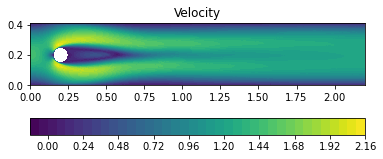

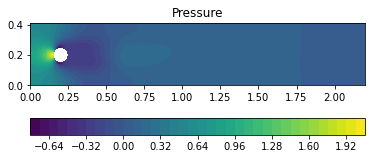

Done.

Solving on slab_114 = Ω x (3.49125, 3.52188) ...
Spaces = [v,v,p,]
t = 3.521875000000003:


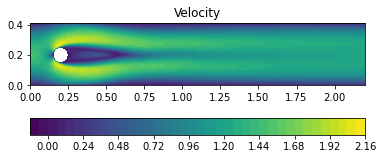

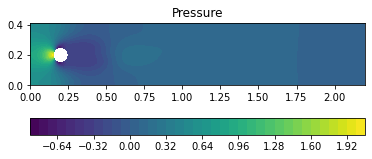

Done.

Solving on slab_115 = Ω x (3.52188, 3.5525) ...
Spaces = [v,v,p,]
t = 3.5525000000000033:


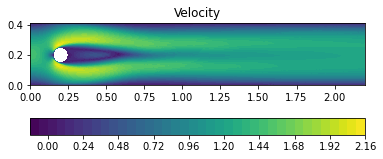

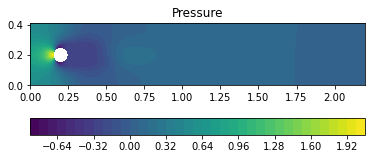

Done.

Solving on slab_116 = Ω x (3.5525, 3.58313) ...
Spaces = [v,v,p,]
t = 3.5831250000000034:


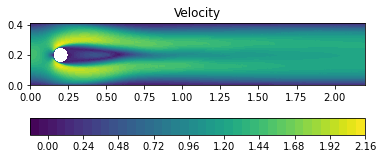

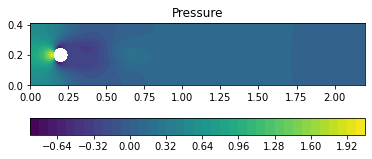

Done.

Solving on slab_117 = Ω x (3.58313, 3.61375) ...
Spaces = [v,v,p,]
t = 3.6137500000000036:


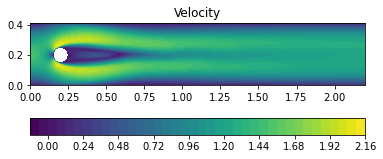

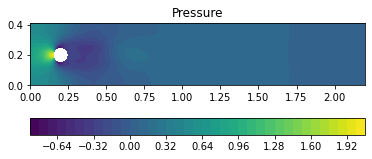

Done.

Solving on slab_118 = Ω x (3.61375, 3.64438) ...
Spaces = [v,v,p,]
t = 3.6443750000000037:


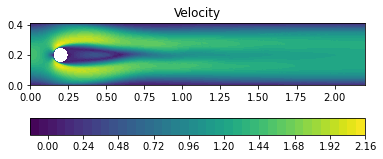

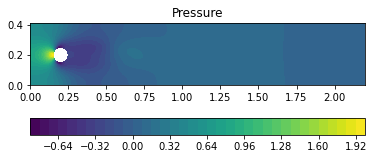

Done.

Solving on slab_119 = Ω x (3.64438, 3.675) ...
Spaces = [v,v,p,]
t = 3.675000000000004:


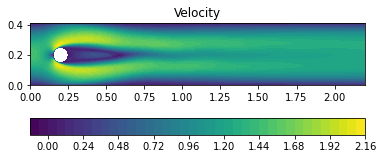

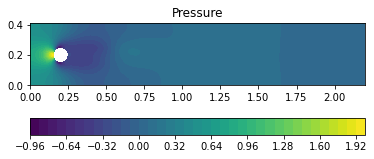

Done.

Solving on slab_120 = Ω x (3.675, 3.70563) ...
Spaces = [v,v,p,]
t = 3.705625000000004:


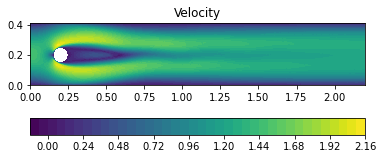

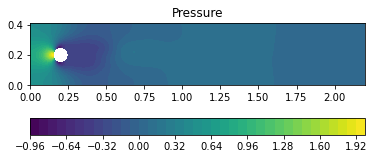

Done.

Solving on slab_121 = Ω x (3.70563, 3.73625) ...
Spaces = [v,v,p,]
t = 3.736250000000004:


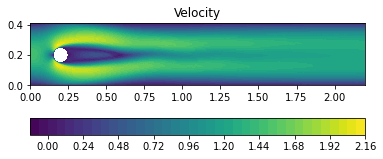

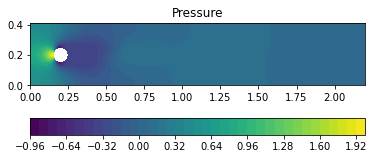

Done.

Solving on slab_122 = Ω x (3.73625, 3.76688) ...
Spaces = [v,v,p,]
t = 3.766875000000004:


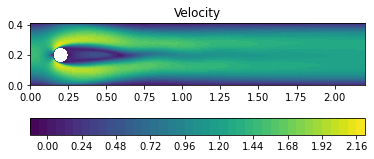

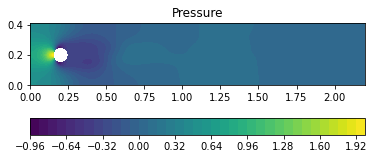

Done.

Solving on slab_123 = Ω x (3.76688, 3.7975) ...
Spaces = [v,v,p,]
t = 3.7975000000000043:


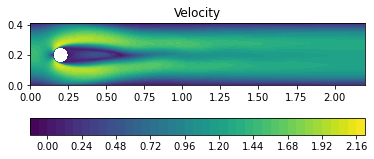

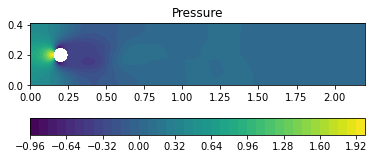

Done.

Solving on slab_124 = Ω x (3.7975, 3.82813) ...
Spaces = [v,v,p,]
t = 3.8281250000000044:


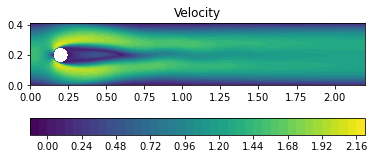

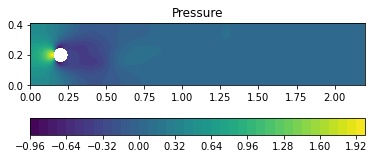

Done.

Solving on slab_125 = Ω x (3.82813, 3.85875) ...
Spaces = [v,v,p,]
t = 3.8587500000000046:


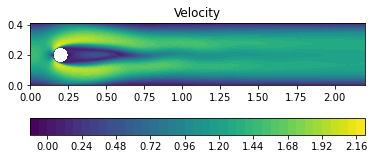

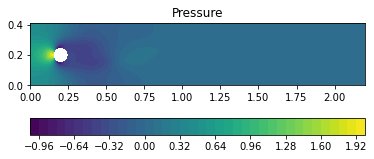

Done.

Solving on slab_126 = Ω x (3.85875, 3.88938) ...
Spaces = [v,v,p,]
t = 3.8893750000000047:


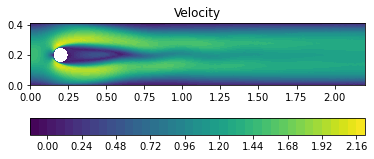

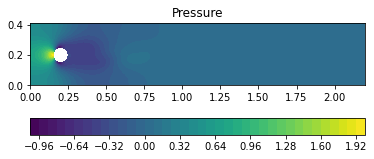

Done.

Solving on slab_127 = Ω x (3.88938, 3.92) ...
Spaces = [v,v,p,]
t = 3.920000000000005:


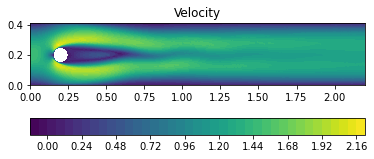

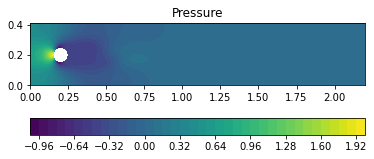

Done.

Solving on slab_128 = Ω x (3.92, 3.95063) ...
Spaces = [v,v,p,]
t = 3.950625000000005:


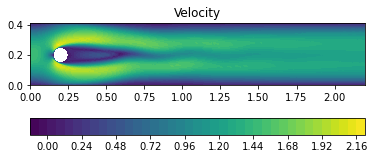

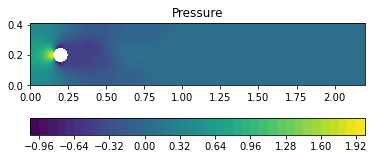

Done.

Solving on slab_129 = Ω x (3.95063, 3.98125) ...
Spaces = [v,v,p,]
t = 3.981250000000005:


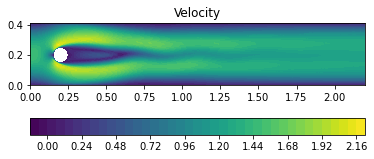

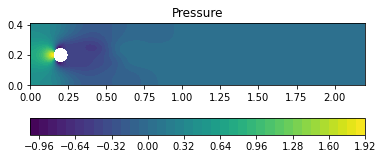

Done.

Solving on slab_130 = Ω x (3.98125, 4.01188) ...
Spaces = [v,v,p,]
t = 4.011875000000005:


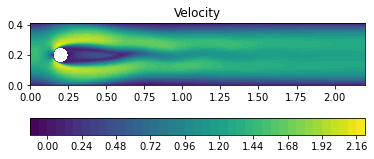

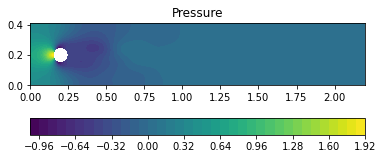

Done.

Solving on slab_131 = Ω x (4.01188, 4.0425) ...
Spaces = [v,v,p,]
t = 4.042500000000005:


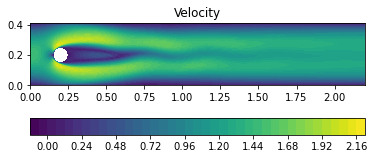

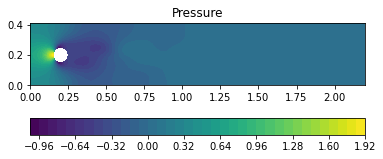

Done.

Solving on slab_132 = Ω x (4.0425, 4.07313) ...
Spaces = [v,v,p,]
t = 4.0731250000000045:


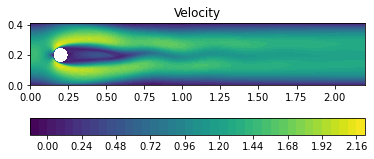

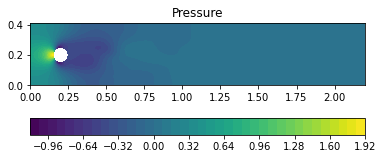

Done.

Solving on slab_133 = Ω x (4.07313, 4.10375) ...
Spaces = [v,v,p,]
t = 4.103750000000004:


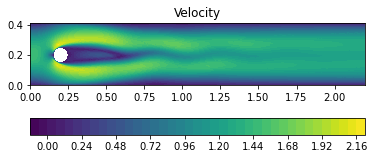

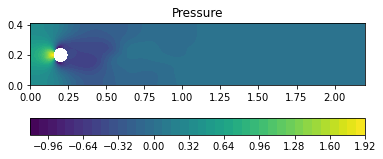

Done.

Solving on slab_134 = Ω x (4.10375, 4.13438) ...
Spaces = [v,v,p,]
t = 4.134375000000004:


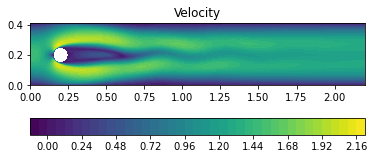

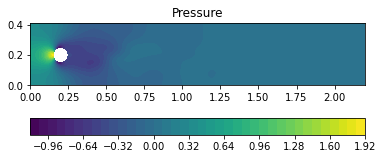

Done.

Solving on slab_135 = Ω x (4.13438, 4.165) ...
Spaces = [v,v,p,]
t = 4.165000000000004:


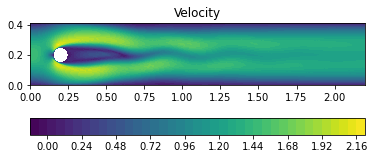

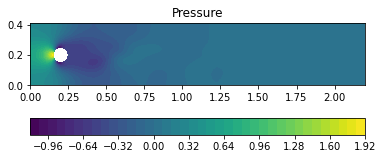

Done.

Solving on slab_136 = Ω x (4.165, 4.19563) ...
Spaces = [v,v,p,]
t = 4.195625000000003:


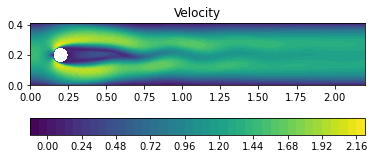

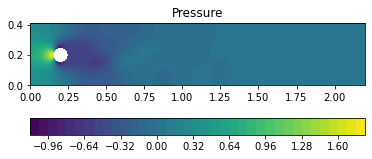

Done.

Solving on slab_137 = Ω x (4.19563, 4.22625) ...
Spaces = [v,v,p,]
t = 4.226250000000003:


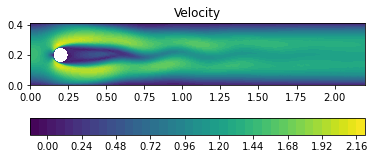

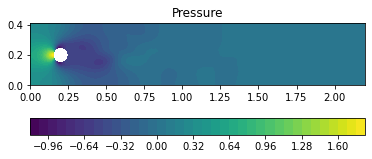

Done.

Solving on slab_138 = Ω x (4.22625, 4.25688) ...
Spaces = [v,v,p,]
t = 4.256875000000003:


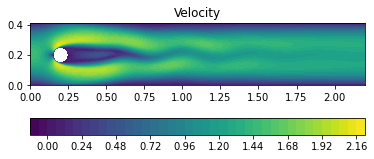

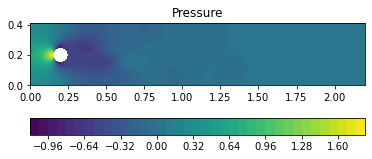

Done.

Solving on slab_139 = Ω x (4.25688, 4.2875) ...
Spaces = [v,v,p,]
t = 4.287500000000002:


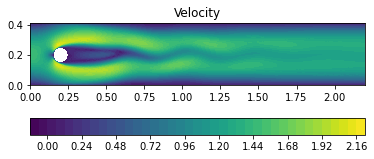

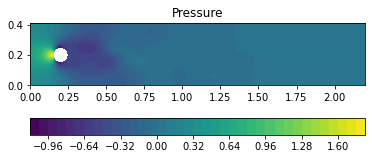

Done.

Solving on slab_140 = Ω x (4.2875, 4.31813) ...
Spaces = [v,v,p,]
t = 4.318125000000002:


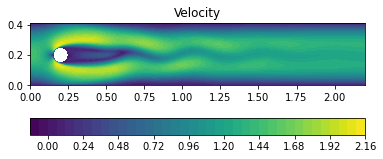

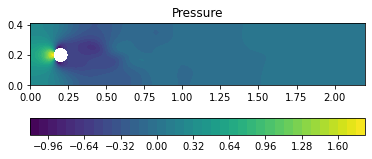

Done.

Solving on slab_141 = Ω x (4.31813, 4.34875) ...
Spaces = [v,v,p,]
t = 4.348750000000002:


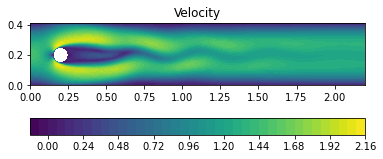

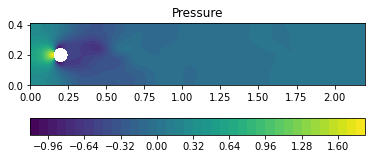

Done.

Solving on slab_142 = Ω x (4.34875, 4.37938) ...
Spaces = [v,v,p,]
t = 4.379375000000001:


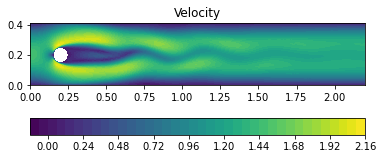

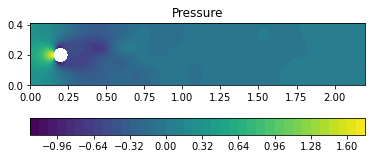

Done.

Solving on slab_143 = Ω x (4.37938, 4.41) ...
Spaces = [v,v,p,]
t = 4.410000000000001:


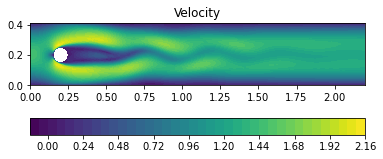

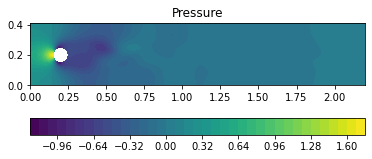

Done.

Solving on slab_144 = Ω x (4.41, 4.44063) ...
Spaces = [v,v,p,]
t = 4.440625000000001:


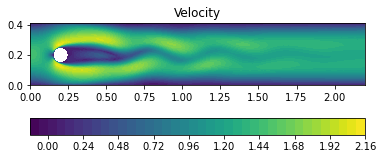

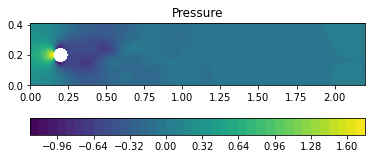

Done.

Solving on slab_145 = Ω x (4.44063, 4.47125) ...
Spaces = [v,v,p,]
t = 4.47125:


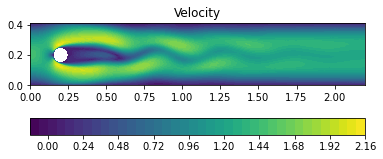

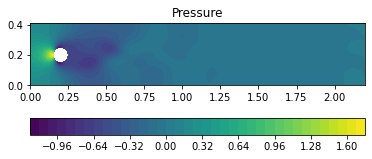

Done.

Solving on slab_146 = Ω x (4.47125, 4.50188) ...
Spaces = [v,v,p,]
t = 4.501875:


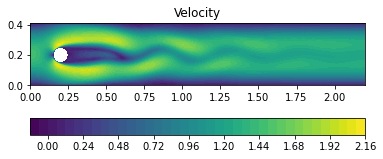

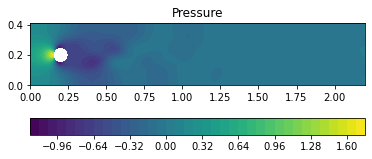

Done.

Solving on slab_147 = Ω x (4.50188, 4.5325) ...
Spaces = [v,v,p,]
t = 4.5325:


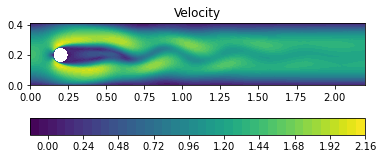

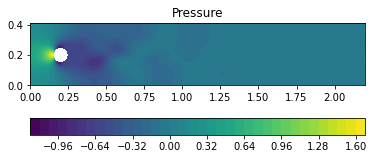

Done.

Solving on slab_148 = Ω x (4.5325, 4.56312) ...
Spaces = [v,v,p,]
t = 4.563124999999999:


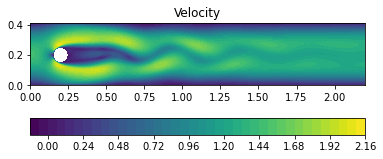

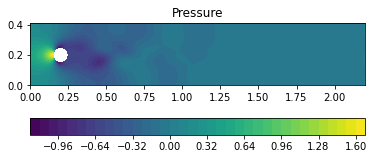

Done.

Solving on slab_149 = Ω x (4.56312, 4.59375) ...
Spaces = [v,v,p,]
t = 4.593749999999999:


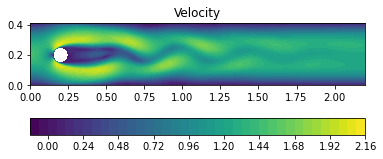

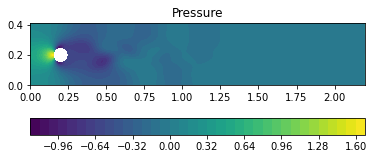

Done.

Solving on slab_150 = Ω x (4.59375, 4.62437) ...
Spaces = [v,v,p,]
t = 4.624374999999999:


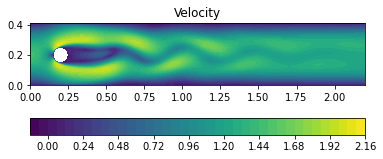

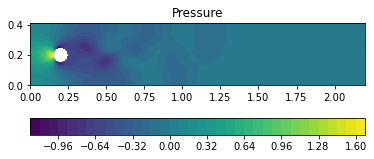

Done.

Solving on slab_151 = Ω x (4.62437, 4.655) ...
Spaces = [v,v,p,]
t = 4.6549999999999985:


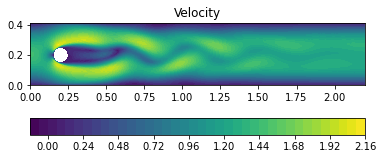

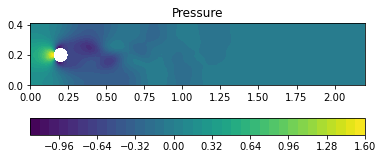

Done.

Solving on slab_152 = Ω x (4.655, 4.68562) ...
Spaces = [v,v,p,]
t = 4.685624999999998:


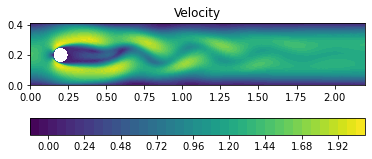

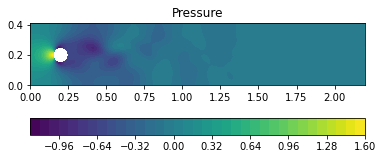

Done.

Solving on slab_153 = Ω x (4.68562, 4.71625) ...
Spaces = [v,v,p,]
t = 4.716249999999998:


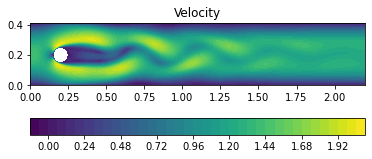

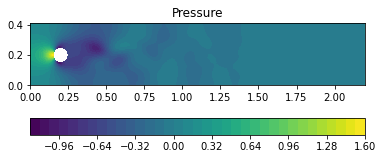

Done.

Solving on slab_154 = Ω x (4.71625, 4.74687) ...
Spaces = [v,v,p,]
t = 4.7468749999999975:


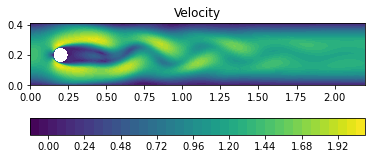

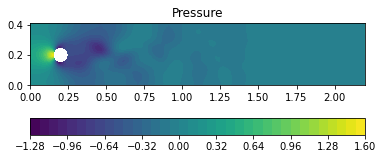

Done.

Solving on slab_155 = Ω x (4.74687, 4.7775) ...
Spaces = [v,v,p,]
t = 4.777499999999997:


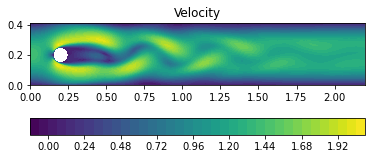

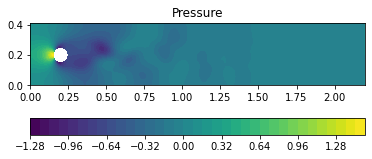

Done.

Solving on slab_156 = Ω x (4.7775, 4.80812) ...
Spaces = [v,v,p,]
t = 4.808124999999997:


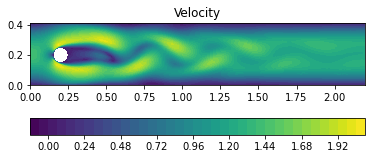

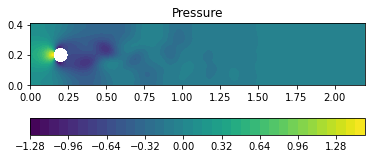

Done.

Solving on slab_157 = Ω x (4.80812, 4.83875) ...
Spaces = [v,v,p,]
t = 4.8387499999999966:


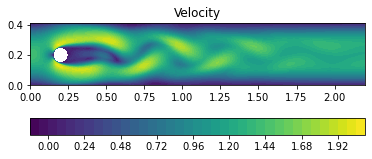

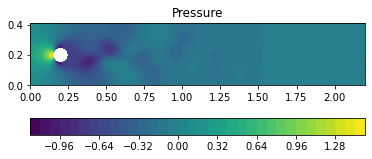

Done.

Solving on slab_158 = Ω x (4.83875, 4.86937) ...
Spaces = [v,v,p,]
t = 4.869374999999996:


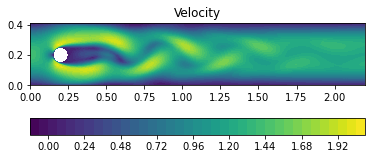

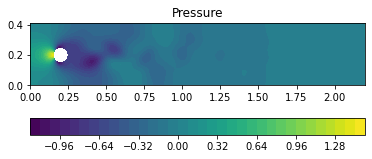

Done.

Solving on slab_159 = Ω x (4.86937, 4.9) ...
Spaces = [v,v,p,]
t = 4.899999999999996:


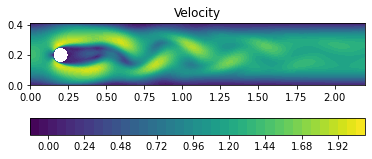

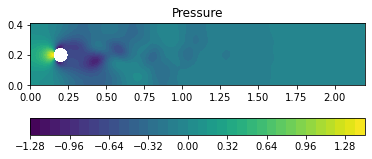

Done.

Solving on slab_160 = Ω x (4.9, 4.93062) ...
Spaces = [v,v,p,]
t = 4.930624999999996:


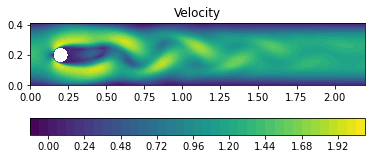

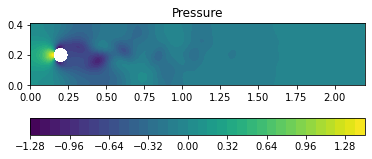

Done.

Solving on slab_161 = Ω x (4.93062, 4.96125) ...
Spaces = [v,v,p,]
t = 4.961249999999995:


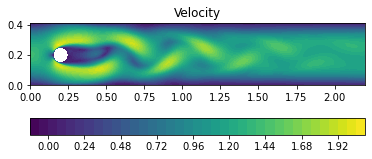

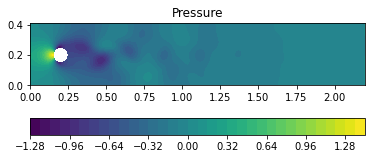

Done.

Solving on slab_162 = Ω x (4.96125, 4.99187) ...
Spaces = [v,v,p,]
t = 4.991874999999995:


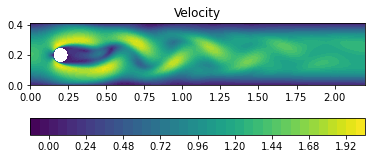

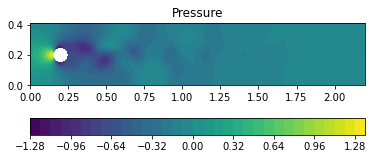

Done.

Solving on slab_163 = Ω x (4.99187, 5.0225) ...
Spaces = [v,v,p,]
t = 5.022499999999995:


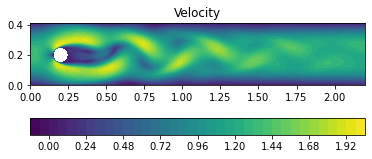

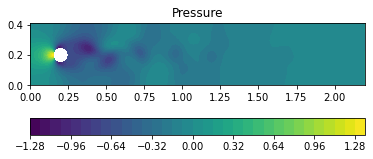

Done.

Solving on slab_164 = Ω x (5.0225, 5.05312) ...
Spaces = [v,v,p,]
t = 5.053124999999994:


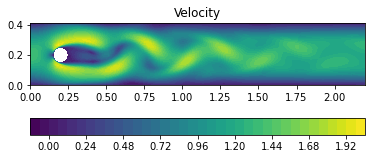

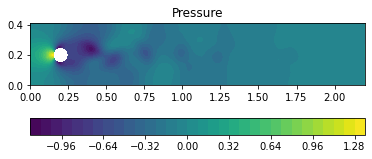

Done.

Solving on slab_165 = Ω x (5.05312, 5.08375) ...
Spaces = [v,v,p,]
t = 5.083749999999994:


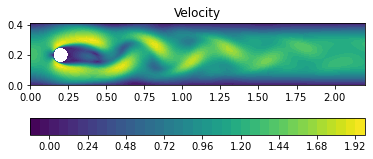

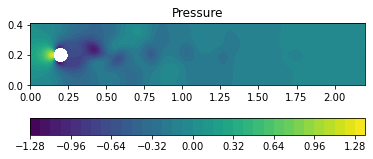

Done.

Solving on slab_166 = Ω x (5.08375, 5.11437) ...
Spaces = [v,v,p,]
t = 5.114374999999994:


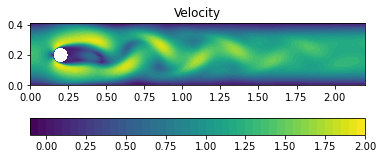

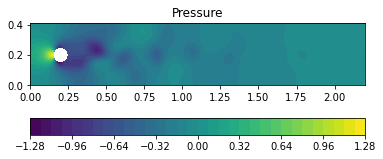

Done.

Solving on slab_167 = Ω x (5.11437, 5.145) ...
Spaces = [v,v,p,]
t = 5.144999999999993:


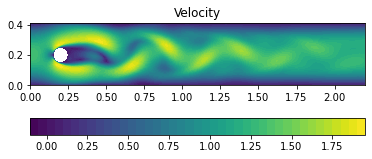

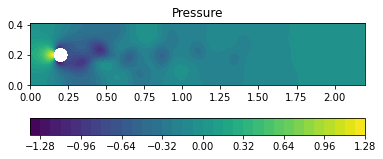

Done.

Solving on slab_168 = Ω x (5.145, 5.17562) ...
Spaces = [v,v,p,]
t = 5.175624999999993:


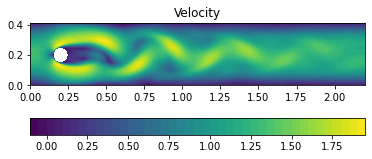

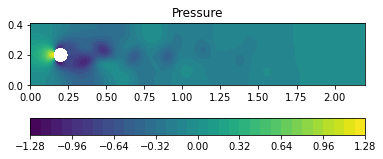

Done.

Solving on slab_169 = Ω x (5.17562, 5.20625) ...
Spaces = [v,v,p,]
t = 5.206249999999993:


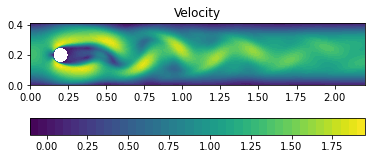

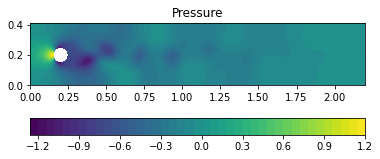

Done.

Solving on slab_170 = Ω x (5.20625, 5.23687) ...
Spaces = [v,v,p,]
t = 5.236874999999992:


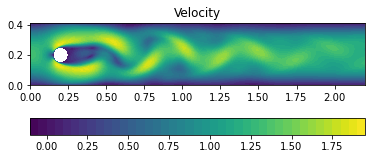

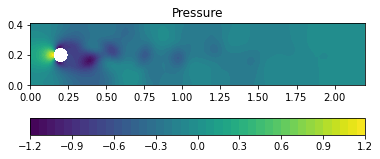

Done.

Solving on slab_171 = Ω x (5.23687, 5.2675) ...
Spaces = [v,v,p,]
t = 5.267499999999992:


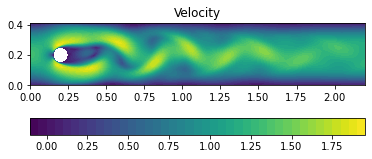

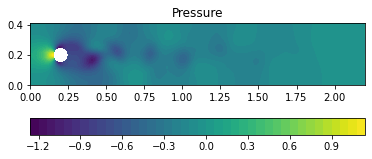

Done.

Solving on slab_172 = Ω x (5.2675, 5.29812) ...
Spaces = [v,v,p,]
t = 5.298124999999992:


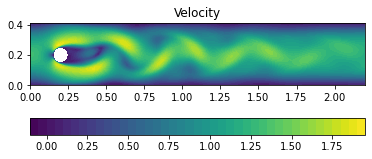

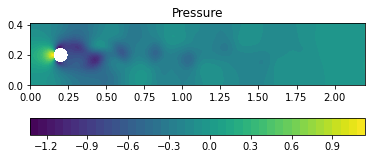

Done.

Solving on slab_173 = Ω x (5.29812, 5.32875) ...
Spaces = [v,v,p,]
t = 5.328749999999991:


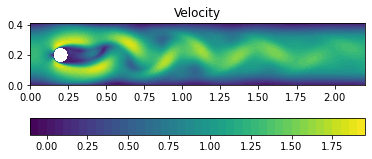

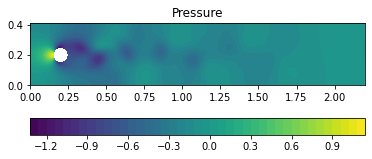

Done.

Solving on slab_174 = Ω x (5.32875, 5.35937) ...
Spaces = [v,v,p,]
t = 5.359374999999991:


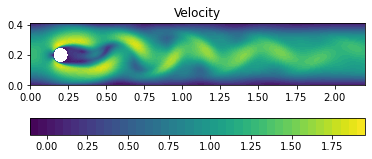

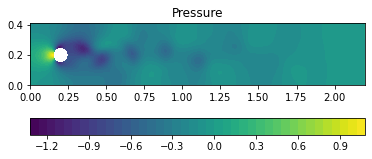

Done.

Solving on slab_175 = Ω x (5.35937, 5.39) ...
Spaces = [v,v,p,]
t = 5.389999999999991:


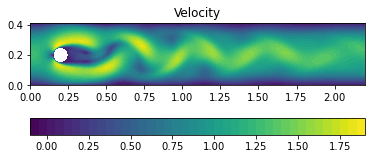

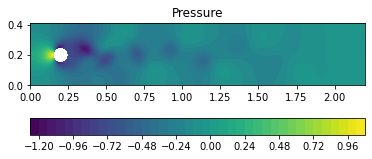

Done.

Solving on slab_176 = Ω x (5.39, 5.42062) ...
Spaces = [v,v,p,]
t = 5.4206249999999905:


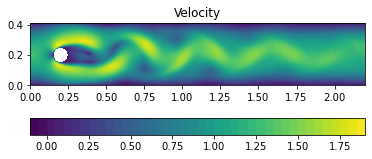

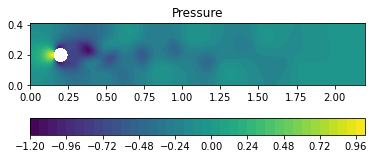

Done.

Solving on slab_177 = Ω x (5.42062, 5.45125) ...
Spaces = [v,v,p,]
t = 5.45124999999999:


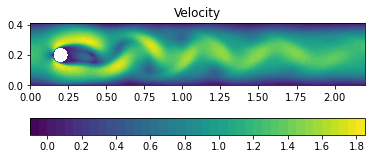

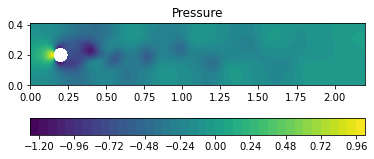

Done.

Solving on slab_178 = Ω x (5.45125, 5.48187) ...
Spaces = [v,v,p,]
t = 5.48187499999999:


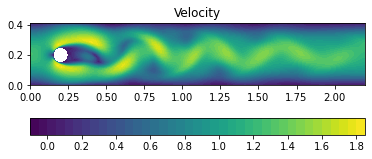

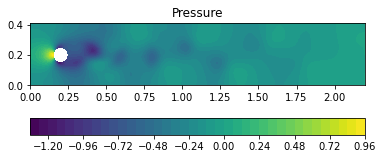

Done.

Solving on slab_179 = Ω x (5.48187, 5.5125) ...
Spaces = [v,v,p,]
t = 5.5124999999999895:


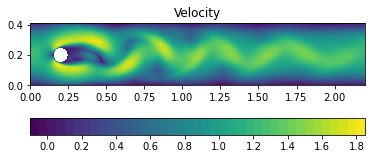

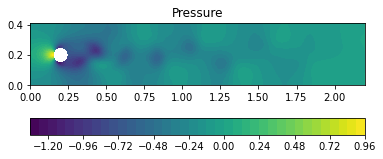

Done.

Solving on slab_180 = Ω x (5.5125, 5.54312) ...
Spaces = [v,v,p,]
t = 5.543124999999989:


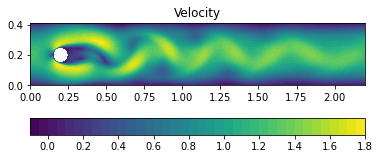

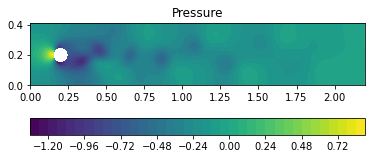

Done.

Solving on slab_181 = Ω x (5.54312, 5.57375) ...
Spaces = [v,v,p,]
t = 5.573749999999989:


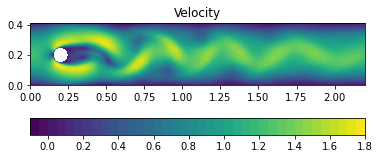

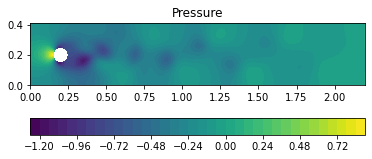

Done.

Solving on slab_182 = Ω x (5.57375, 5.60437) ...
Spaces = [v,v,p,]
t = 5.604374999999989:


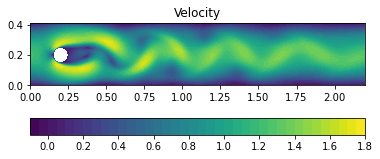

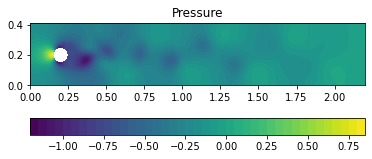

Done.

Solving on slab_183 = Ω x (5.60437, 5.635) ...
Spaces = [v,v,p,]
t = 5.634999999999988:


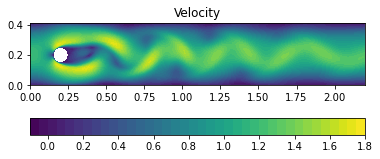

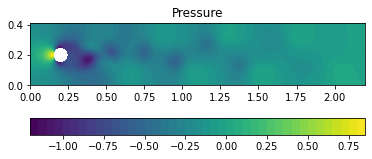

Done.

Solving on slab_184 = Ω x (5.635, 5.66562) ...
Spaces = [v,v,p,]
t = 5.665624999999988:


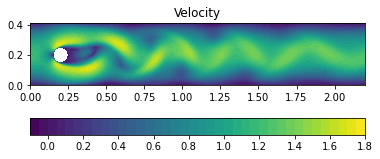

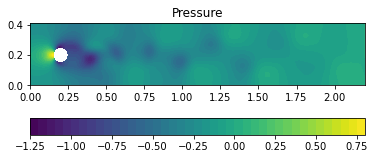

Done.

Solving on slab_185 = Ω x (5.66562, 5.69625) ...
Spaces = [v,v,p,]
t = 5.696249999999988:


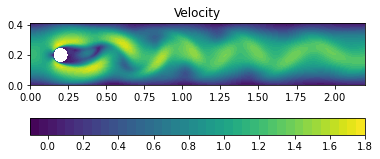

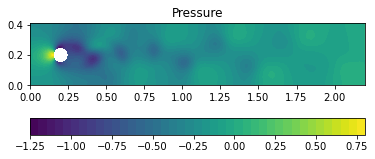

Done.

Solving on slab_186 = Ω x (5.69625, 5.72687) ...
Spaces = [v,v,p,]
t = 5.726874999999987:


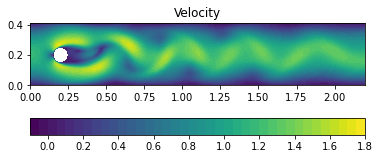

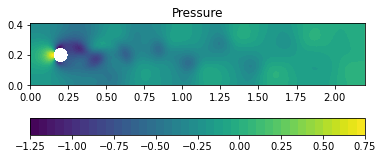

Done.

Solving on slab_187 = Ω x (5.72687, 5.7575) ...
Spaces = [v,v,p,]
t = 5.757499999999987:


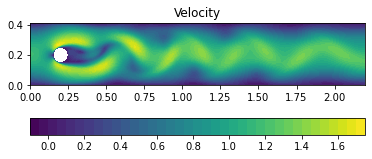

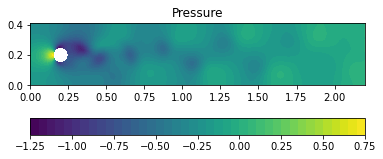

Done.

Solving on slab_188 = Ω x (5.7575, 5.78812) ...
Spaces = [v,v,p,]
t = 5.788124999999987:


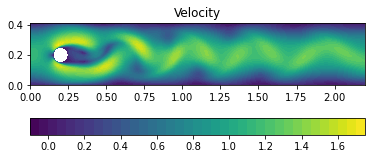

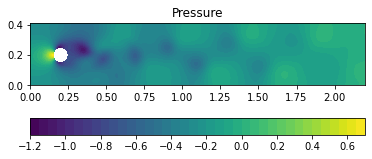

Done.

Solving on slab_189 = Ω x (5.78812, 5.81875) ...
Spaces = [v,v,p,]
t = 5.818749999999986:


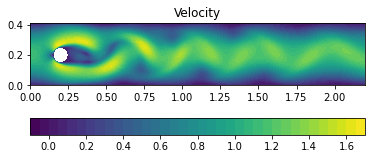

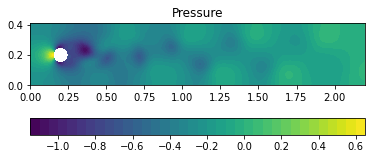

Done.

Solving on slab_190 = Ω x (5.81875, 5.84937) ...
Spaces = [v,v,p,]
t = 5.849374999999986:


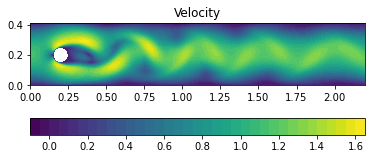

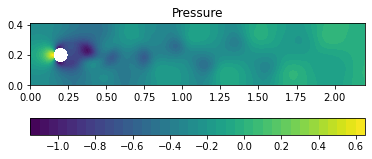

Done.

Solving on slab_191 = Ω x (5.84937, 5.88) ...
Spaces = [v,v,p,]
t = 5.879999999999986:


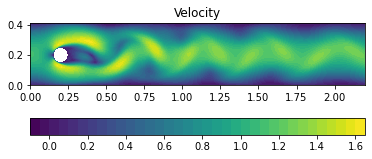

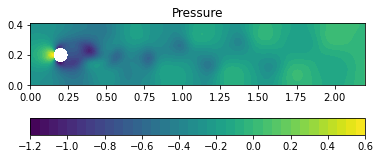

Done.

Solving on slab_192 = Ω x (5.88, 5.91062) ...
Spaces = [v,v,p,]
t = 5.910624999999985:


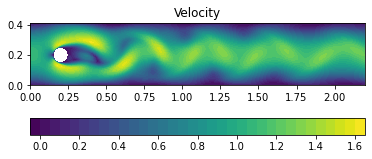

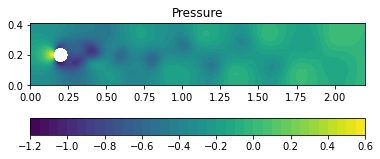

Done.

Solving on slab_193 = Ω x (5.91062, 5.94125) ...
Spaces = [v,v,p,]
t = 5.941249999999985:


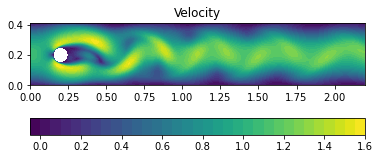

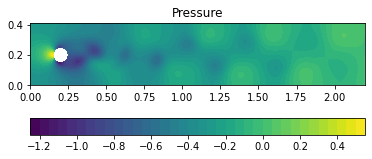

Done.

Solving on slab_194 = Ω x (5.94125, 5.97187) ...
Spaces = [v,v,p,]
t = 5.971874999999985:


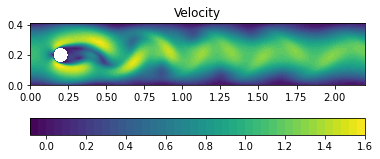

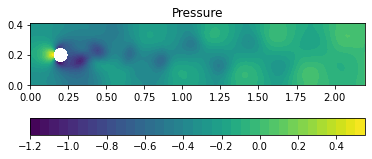

Done.

Solving on slab_195 = Ω x (5.97187, 6.0025) ...
Spaces = [v,v,p,]
t = 6.002499999999984:


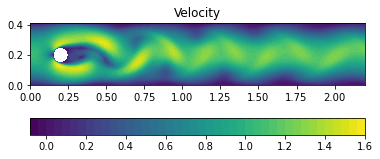

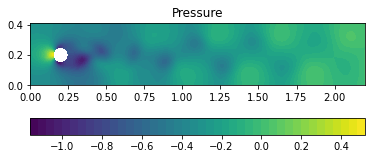

Done.

Solving on slab_196 = Ω x (6.0025, 6.03312) ...
Spaces = [v,v,p,]
t = 6.033124999999984:


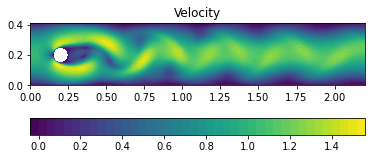

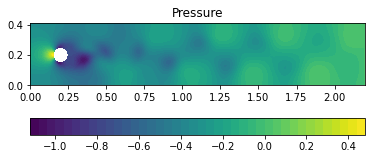

Done.

Solving on slab_197 = Ω x (6.03312, 6.06375) ...
Spaces = [v,v,p,]
t = 6.063749999999984:


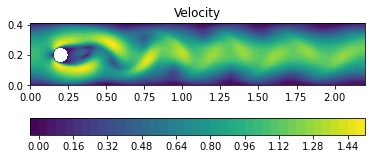

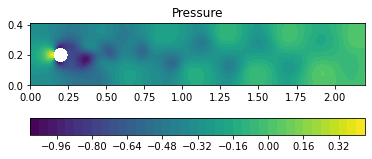

Done.

Solving on slab_198 = Ω x (6.06375, 6.09437) ...
Spaces = [v,v,p,]
t = 6.0943749999999834:


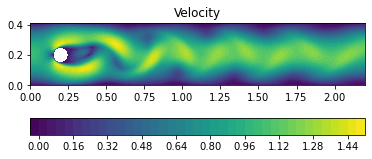

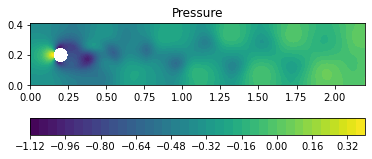

Done.

Solving on slab_199 = Ω x (6.09437, 6.125) ...
Spaces = [v,v,p,]
t = 6.124999999999983:


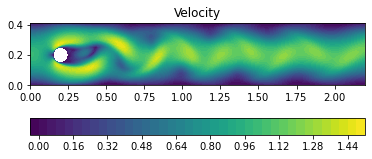

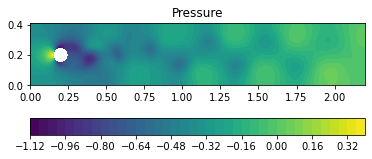

Done.

Solving on slab_200 = Ω x (6.125, 6.15562) ...
Spaces = [v,v,p,]
t = 6.155624999999983:


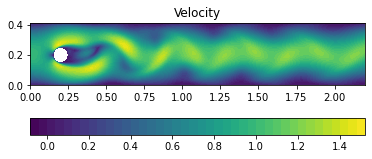

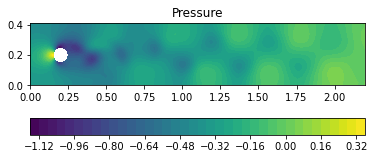

Done.

Solving on slab_201 = Ω x (6.15562, 6.18625) ...
Spaces = [v,v,p,]
t = 6.1862499999999825:


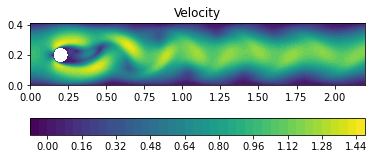

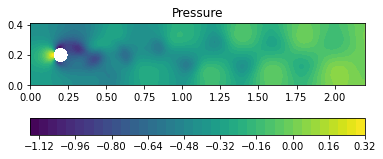

Done.

Solving on slab_202 = Ω x (6.18625, 6.21687) ...
Spaces = [v,v,p,]
t = 6.216874999999982:


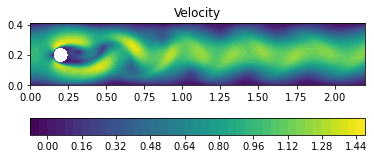

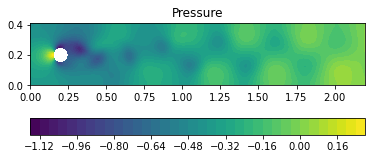

Done.

Solving on slab_203 = Ω x (6.21687, 6.2475) ...
Spaces = [v,v,p,]
t = 6.247499999999982:


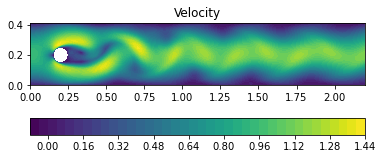

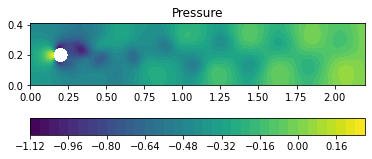

Done.

Solving on slab_204 = Ω x (6.2475, 6.27812) ...
Spaces = [v,v,p,]
t = 6.2781249999999815:


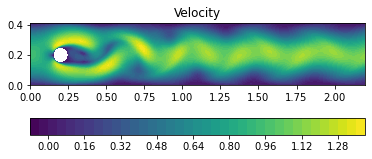

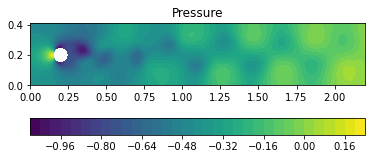

Done.

Solving on slab_205 = Ω x (6.27812, 6.30875) ...
Spaces = [v,v,p,]
t = 6.308749999999981:


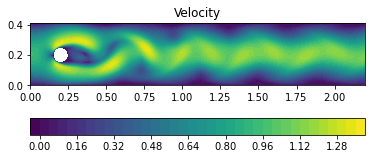

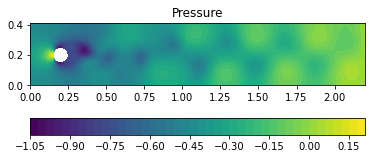

Done.

Solving on slab_206 = Ω x (6.30875, 6.33937) ...
Spaces = [v,v,p,]
t = 6.339374999999981:


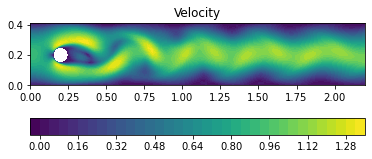

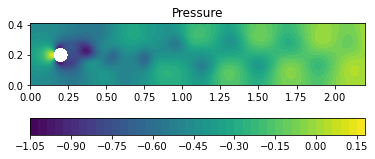

Done.

Solving on slab_207 = Ω x (6.33937, 6.37) ...
Spaces = [v,v,p,]
t = 6.369999999999981:


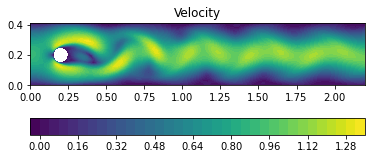

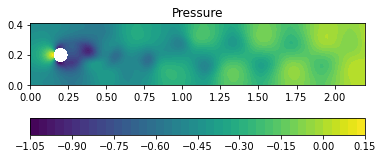

Done.

Solving on slab_208 = Ω x (6.37, 6.40062) ...
Spaces = [v,v,p,]
t = 6.40062499999998:


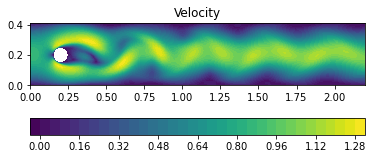

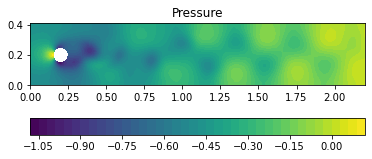

Done.

Solving on slab_209 = Ω x (6.40062, 6.43125) ...
Spaces = [v,v,p,]
t = 6.43124999999998:


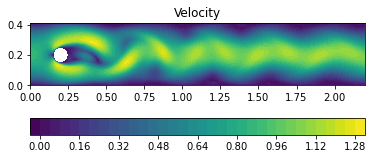

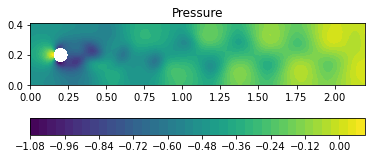

Done.

Solving on slab_210 = Ω x (6.43125, 6.46187) ...
Spaces = [v,v,p,]
t = 6.46187499999998:


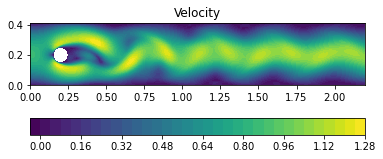

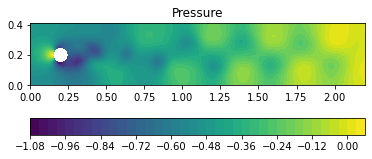

Done.

Solving on slab_211 = Ω x (6.46187, 6.4925) ...
Spaces = [v,v,p,]
t = 6.492499999999979:


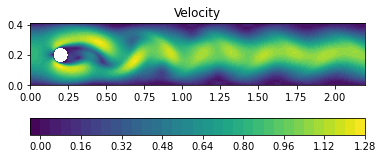

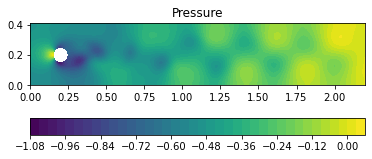

Done.

Solving on slab_212 = Ω x (6.4925, 6.52312) ...
Spaces = [v,v,p,]
t = 6.523124999999979:


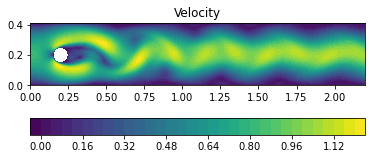

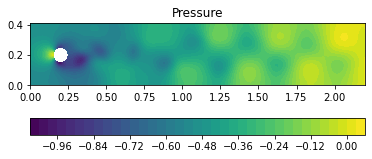

Done.

Solving on slab_213 = Ω x (6.52312, 6.55375) ...
Spaces = [v,v,p,]
t = 6.553749999999979:


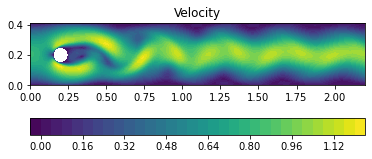

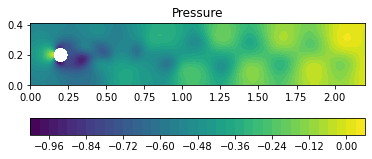

Done.

Solving on slab_214 = Ω x (6.55375, 6.58437) ...
Spaces = [v,v,p,]
t = 6.584374999999978:


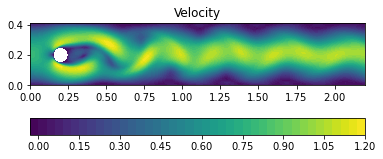

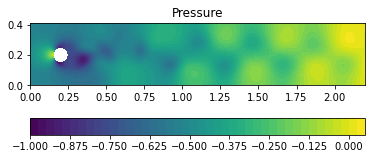

Done.

Solving on slab_215 = Ω x (6.58437, 6.615) ...
Spaces = [v,v,p,]
t = 6.614999999999978:


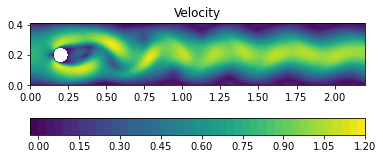

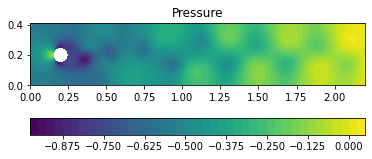

Done.

Solving on slab_216 = Ω x (6.615, 6.64562) ...
Spaces = [v,v,p,]
t = 6.645624999999978:


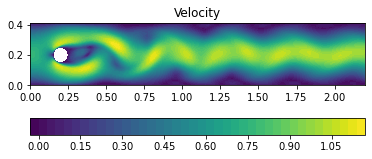

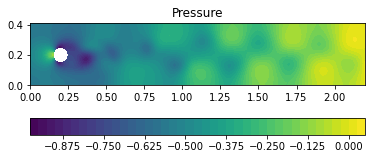

Done.

Solving on slab_217 = Ω x (6.64562, 6.67625) ...
Spaces = [v,v,p,]
t = 6.676249999999977:


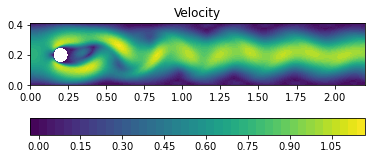

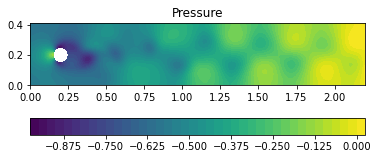

Done.

Solving on slab_218 = Ω x (6.67625, 6.70687) ...
Spaces = [v,v,p,]
t = 6.706874999999977:


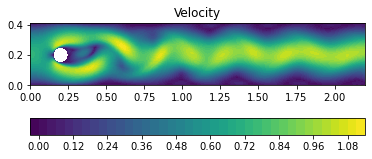

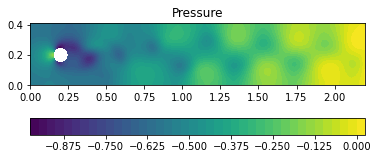

Done.

Solving on slab_219 = Ω x (6.70687, 6.7375) ...
Spaces = [v,v,p,]
t = 6.737499999999977:


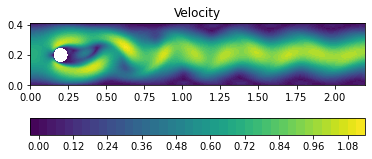

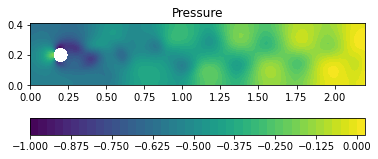

Done.

Solving on slab_220 = Ω x (6.7375, 6.76812) ...
Spaces = [v,v,p,]
t = 6.768124999999976:


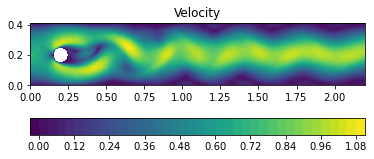

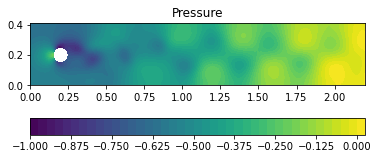

Done.

Solving on slab_221 = Ω x (6.76812, 6.79875) ...
Spaces = [v,v,p,]
t = 6.798749999999976:


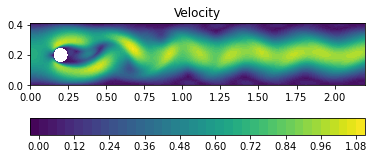

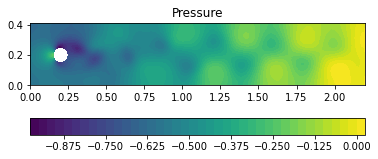

Done.

Solving on slab_222 = Ω x (6.79875, 6.82937) ...
Spaces = [v,v,p,]
t = 6.829374999999976:


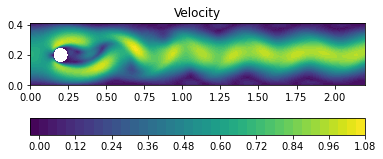

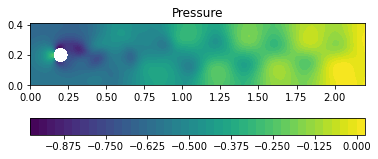

Done.

Solving on slab_223 = Ω x (6.82937, 6.86) ...
Spaces = [v,v,p,]
t = 6.8599999999999755:


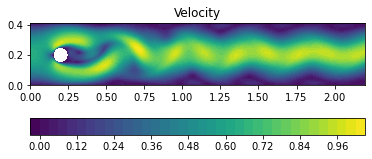

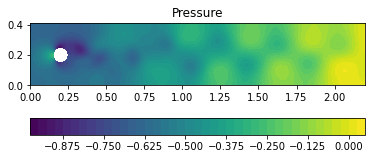

Done.

Solving on slab_224 = Ω x (6.86, 6.89062) ...
Spaces = [v,v,p,]
t = 6.890624999999975:


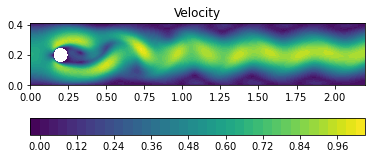

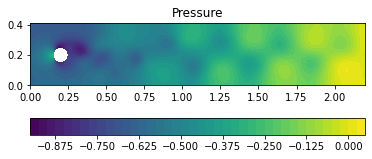

Done.

Solving on slab_225 = Ω x (6.89062, 6.92125) ...
Spaces = [v,v,p,]
t = 6.921249999999975:


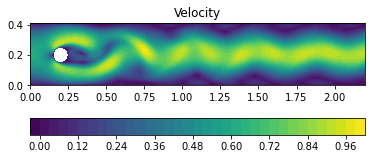

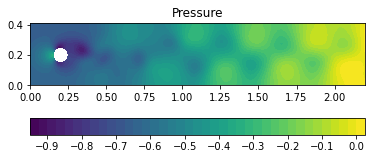

Done.

Solving on slab_226 = Ω x (6.92125, 6.95187) ...
Spaces = [v,v,p,]
t = 6.9518749999999745:


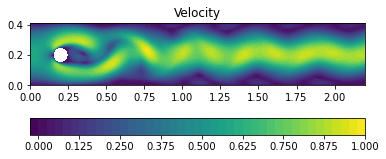

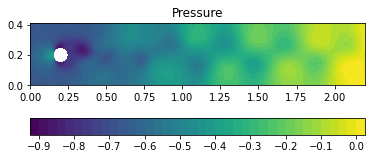

Done.

Solving on slab_227 = Ω x (6.95187, 6.9825) ...
Spaces = [v,v,p,]
t = 6.982499999999974:


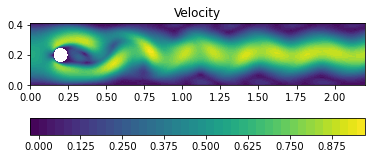

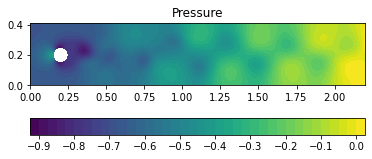

Done.

Solving on slab_228 = Ω x (6.9825, 7.01312) ...
Spaces = [v,v,p,]
t = 7.013124999999974:


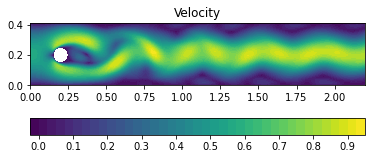

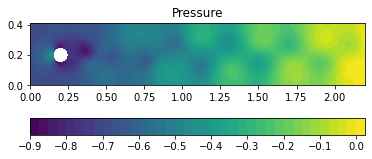

Done.

Solving on slab_229 = Ω x (7.01312, 7.04375) ...
Spaces = [v,v,p,]
t = 7.0437499999999735:


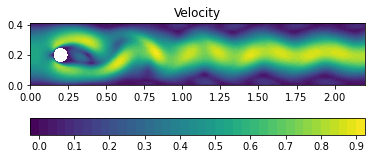

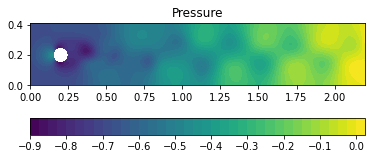

Done.

Solving on slab_230 = Ω x (7.04375, 7.07437) ...
Spaces = [v,v,p,]
t = 7.074374999999973:


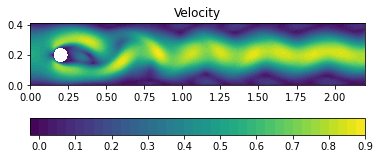

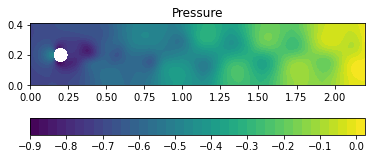

Done.

Solving on slab_231 = Ω x (7.07437, 7.105) ...
Spaces = [v,v,p,]
t = 7.104999999999973:


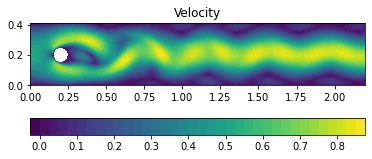

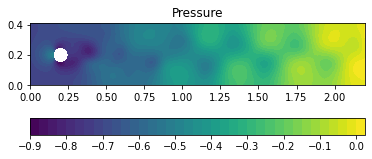

Done.

Solving on slab_232 = Ω x (7.105, 7.13562) ...
Spaces = [v,v,p,]
t = 7.135624999999973:


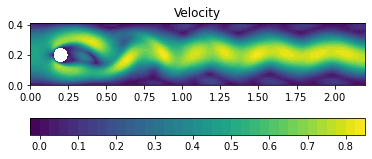

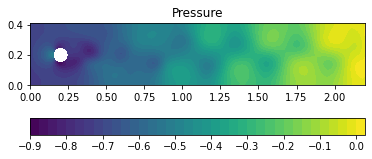

Done.

Solving on slab_233 = Ω x (7.13562, 7.16625) ...
Spaces = [v,v,p,]
t = 7.166249999999972:


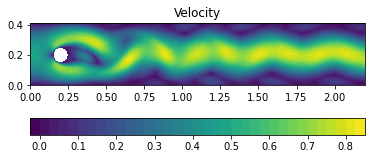

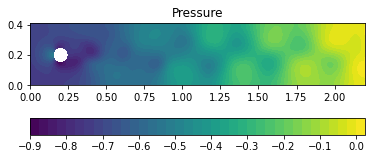

Done.

Solving on slab_234 = Ω x (7.16625, 7.19687) ...
Spaces = [v,v,p,]
t = 7.196874999999972:


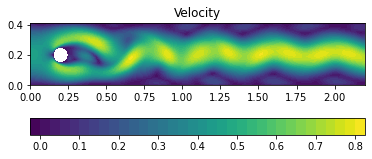

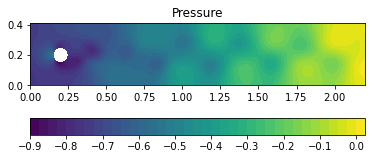

Done.

Solving on slab_235 = Ω x (7.19687, 7.2275) ...
Spaces = [v,v,p,]
t = 7.227499999999972:


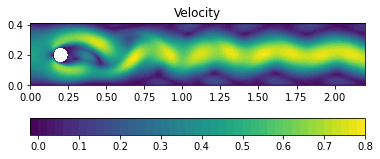

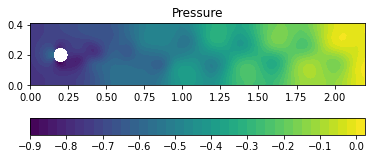

Done.

Solving on slab_236 = Ω x (7.2275, 7.25812) ...
Spaces = [v,v,p,]
t = 7.258124999999971:


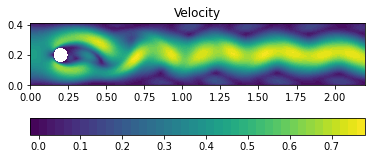

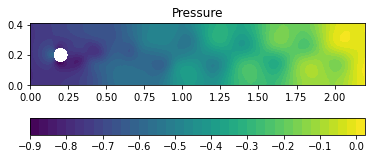

Done.

Solving on slab_237 = Ω x (7.25812, 7.28875) ...
Spaces = [v,v,p,]
t = 7.288749999999971:


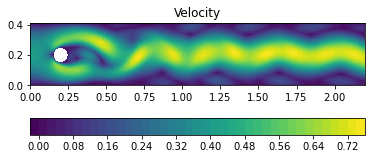

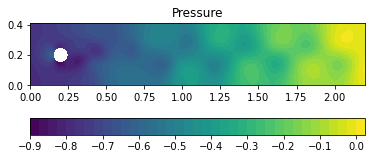

Done.

Solving on slab_238 = Ω x (7.28875, 7.31937) ...
Spaces = [v,v,p,]
t = 7.319374999999971:


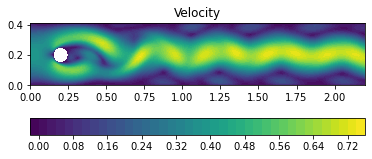

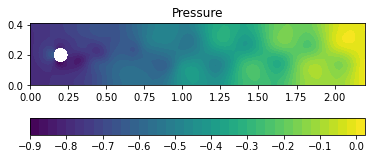

Done.

Solving on slab_239 = Ω x (7.31937, 7.35) ...
Spaces = [v,v,p,]
t = 7.34999999999997:


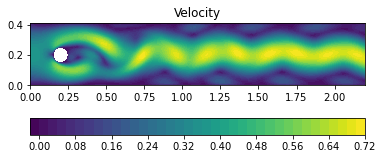

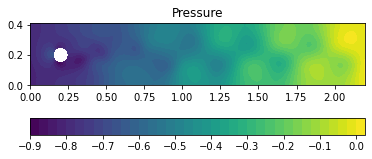

Done.

Solving on slab_240 = Ω x (7.35, 7.38062) ...
Spaces = [v,v,p,]
t = 7.38062499999997:


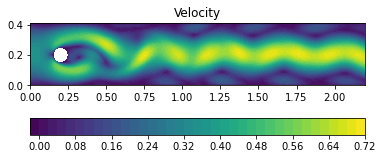

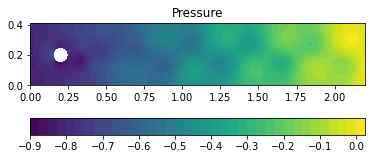

Done.

Solving on slab_241 = Ω x (7.38062, 7.41125) ...
Spaces = [v,v,p,]
t = 7.41124999999997:


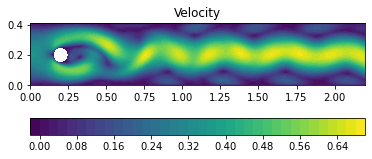

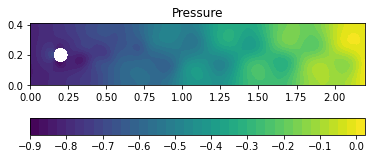

Done.

Solving on slab_242 = Ω x (7.41125, 7.44187) ...
Spaces = [v,v,p,]
t = 7.441874999999969:


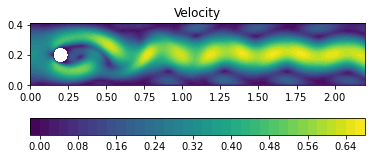

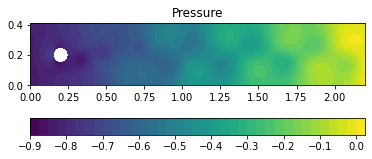

Done.

Solving on slab_243 = Ω x (7.44187, 7.4725) ...
Spaces = [v,v,p,]
t = 7.472499999999969:


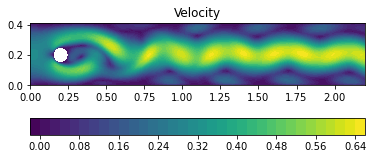

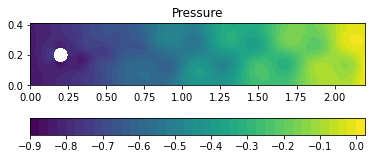

Done.

Solving on slab_244 = Ω x (7.4725, 7.50312) ...
Spaces = [v,v,p,]
t = 7.503124999999969:


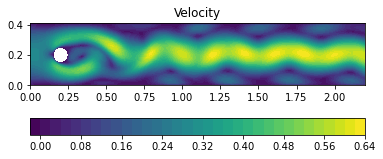

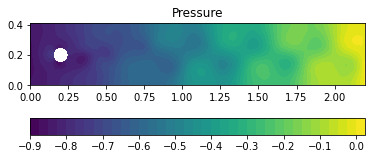

Done.

Solving on slab_245 = Ω x (7.50312, 7.53375) ...
Spaces = [v,v,p,]
t = 7.533749999999968:


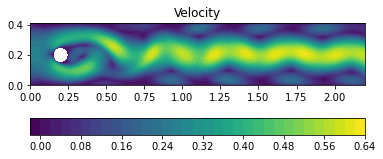

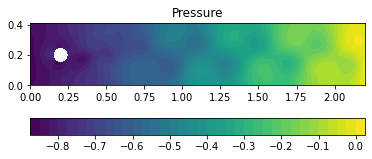

Done.

Solving on slab_246 = Ω x (7.53375, 7.56437) ...
Spaces = [v,v,p,]
t = 7.564374999999968:


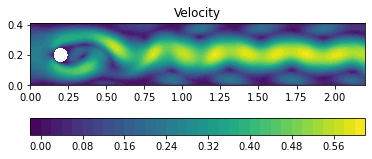

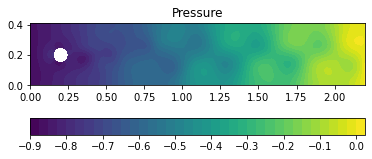

Done.

Solving on slab_247 = Ω x (7.56437, 7.595) ...
Spaces = [v,v,p,]
t = 7.594999999999968:


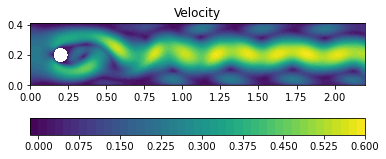

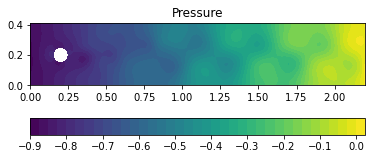

Done.

Solving on slab_248 = Ω x (7.595, 7.62562) ...
Spaces = [v,v,p,]
t = 7.6256249999999675:


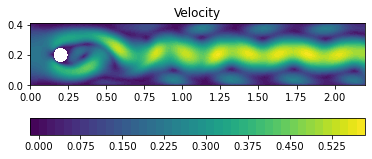

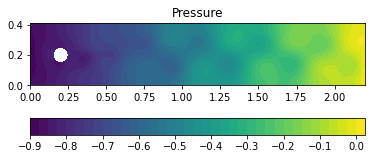

Done.

Solving on slab_249 = Ω x (7.62562, 7.65625) ...
Spaces = [v,v,p,]
t = 7.656249999999967:


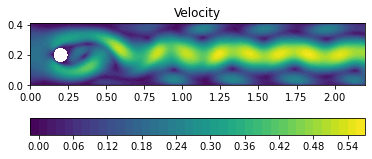

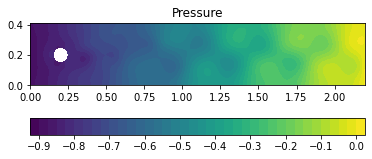

Done.

Solving on slab_250 = Ω x (7.65625, 7.68687) ...
Spaces = [v,v,p,]
t = 7.686874999999967:


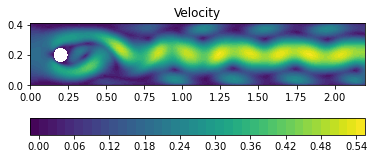

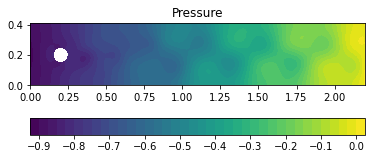

Done.

Solving on slab_251 = Ω x (7.68687, 7.7175) ...
Spaces = [v,v,p,]
t = 7.7174999999999665:


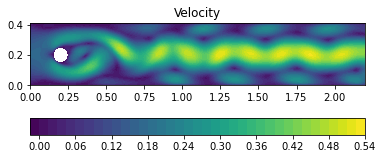

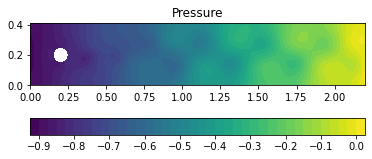

Done.

Solving on slab_252 = Ω x (7.7175, 7.74812) ...
Spaces = [v,v,p,]
t = 7.748124999999966:


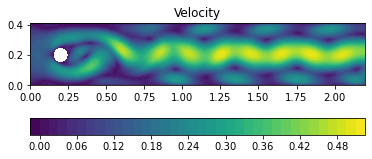

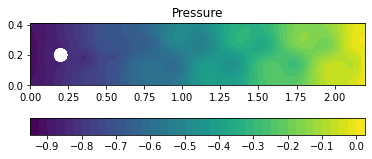

Done.

Solving on slab_253 = Ω x (7.74812, 7.77875) ...
Spaces = [v,v,p,]
t = 7.778749999999966:


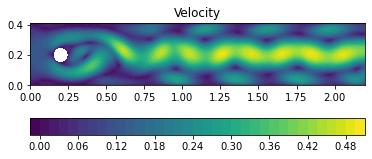

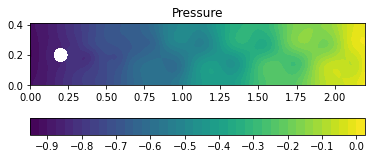

Done.

Solving on slab_254 = Ω x (7.77875, 7.80937) ...
Spaces = [v,v,p,]
t = 7.8093749999999655:


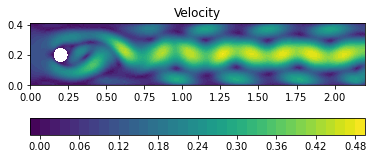

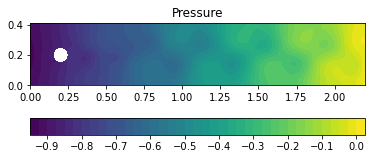

Done.

Solving on slab_255 = Ω x (7.80937, 7.84) ...
Spaces = [v,v,p,]
t = 7.839999999999965:


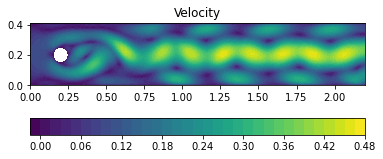

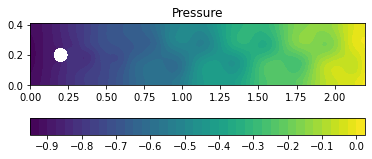

Done.

Solving on slab_256 = Ω x (7.84, 7.87062) ...
Spaces = [v,v,p,]
t = 7.870624999999965:


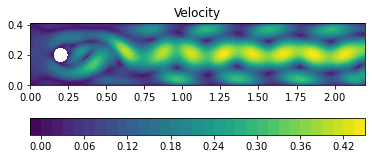

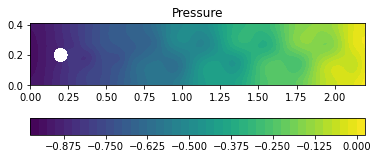

Done.

Solving on slab_257 = Ω x (7.87062, 7.90125) ...
Spaces = [v,v,p,]
t = 7.901249999999965:


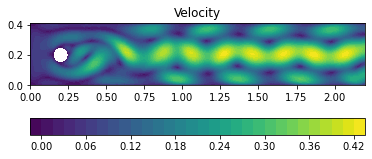

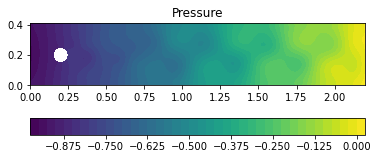

Done.

Solving on slab_258 = Ω x (7.90125, 7.93187) ...
Spaces = [v,v,p,]
t = 7.931874999999964:


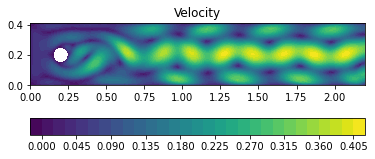

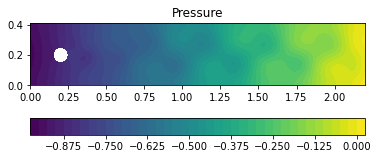

Done.

Solving on slab_259 = Ω x (7.93187, 7.9625) ...
Spaces = [v,v,p,]
t = 7.962499999999964:


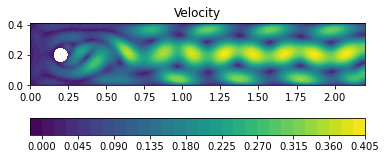

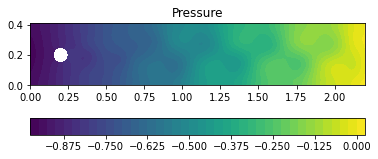

Done.

Solving on slab_260 = Ω x (7.9625, 7.99312) ...
Spaces = [v,v,p,]
t = 7.993124999999964:


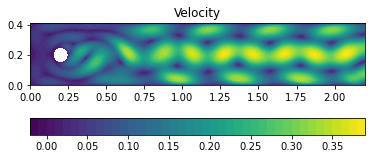

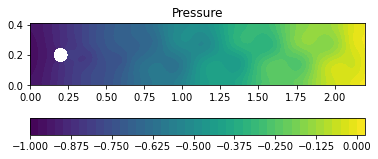

Done.

Solving on slab_261 = Ω x (7.99312, 8.02375) ...
Spaces = [v,v,p,]
t = 8.023749999999964:


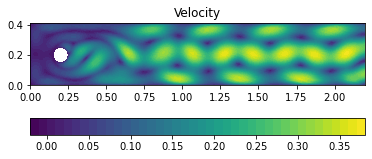

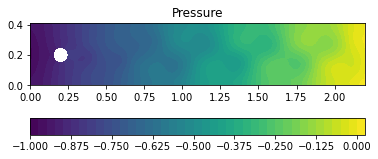

Done.

------------
| RESULTS: |
------------
Space-time Dofs: 13,701,028
CPU Time: 3490.3052 s 




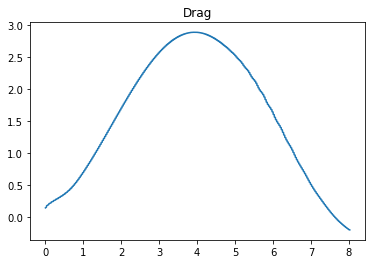

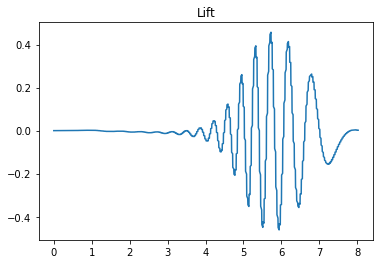

In [17]:
##############################################
# Start a time marching / time slabbing loop #
##############################################
start_time = 0.
end_time = 8.

s_v = 2
s_p = 1
r_v = 1
r_p = 0
slab_size = 0.030625
n_x = 1
nu = 0.001

# start simulation
cpu_start_time = time.time()
print(f"CONFIG: problem = {PROBLEM}, s = ({s_v}/{s_p}), r = ({r_v}/{r_p}) ({TIME_DG_QUADRATURE}), slab_size = {slab_size}, n_x = {n_x}")

slabs = [(start_time, start_time+slab_size)]
while slabs[-1][1] < end_time - 1e-8:
    slabs.append((slabs[-1][1], slabs[-1][1]+slab_size))

# get spatial function space
#space_mesh = Mesh("schaefer_turek_2D_fine.xml") # decent results, fine mesh with ~50 K DoFs for Taylor-Hood
space_mesh = Mesh("schaefer_turek_2D_pygmsh.xml") # mesh with ~28 K DoFs for Taylor-Hood
# space_mesh = Mesh("schaefer_turek_2D.xml") # too coarse for accurate lift
plot(space_mesh, title="spatial mesh")
plt.show()
element = {
    "v": VectorElement("Lagrange", space_mesh.ufl_cell(), s_v),
    "p": FiniteElement("Lagrange", space_mesh.ufl_cell(), s_p),
}
Vh = FunctionSpace(space_mesh, MixedElement(*element.values())) # spatial function space for a single time point
print(f"Number of spatial DoFs: {Vh.dim()} ({Vh.sub(0).dim()} + {Vh.sub(1).dim()})")
Uh = Function(Vh)
Phih = TestFunctions(Vh)

# boundaries
inflow = CompiledSubDomain("near(x[0], 0) && on_boundary")
outflow = CompiledSubDomain("near(x[0], 2.2) && on_boundary")
walls = CompiledSubDomain("near(x[1], 0) || near(x[1], 0.41) && on_boundary")
cylinder = CompiledSubDomain("x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3 && on_boundary")

facet_marker = MeshFunction("size_t", space_mesh, 1)
facet_marker.set_all(0)
inflow.mark(facet_marker, 1)
outflow.mark(facet_marker, 2)
walls.mark(facet_marker, 3)
cylinder.mark(facet_marker, 4)

ds_cylinder = Measure("ds", subdomain_data=facet_marker, subdomain_id=4)

# initial condition on slab
U0 = Function(Vh)
v0, p0 = split(U0)
U0 = interpolate(Constant((0.,0.,0.)), Vh)

# split functions into velocity and pressure components
v, p = split(Uh)
phi_v, phi_p = Phih

# preassemble spatial forms
#mass_form = dot(v, phi_v) * dx
#laplace_form = inner(grad(v), grad(phi_v)) * dx
#pressure_form = p * div(phi_v) * dx
#div_form = div(v) * phi_p * dx
#convection_form = dot(dot(grad(v), v), phi_v) * dx

# pre-assemble drag and lift
dU = TrialFunction(Vh) 
dv, dp = split(dU)
D = 0.1
v_bar = 2/3 * 4.0*1.5*0.205*(0.41 - 0.205) / pow(0.41, 2)
n = FacetNormal(space_mesh)
drag_vector = assemble(
    2/(v_bar**2*D)*
    (
    - dot(dp * Identity(len(dv)) , -n)[0]
    + nu * dot(grad(dv), -n)[0]
    ) * ds_cylinder
).get_local()

lift_vector = assemble(
    2/(v_bar**2*D)*
    (
    - dot(dp * Identity(len(dv)) , -n)[1]
    + nu * dot(grad(dv), -n)[1]
    ) * ds_cylinder
).get_local()

drag_values = []
lift_values = []
times_draglift = []
total_n_dofs = 0

#####################
# Time slabbing loop:
for k, slab in enumerate(slabs):
    print(f"Solving on slab_{k} = Ω x ({round(slab[0],5)}, {round(slab[1],5)}) ...")

    #########################################
    # Create temporal finite element object #
    #########################################
    Time = {
        "v" : TimeFE(r=r_v, a=slab[0], b=slab[1], n_time=1, n_q_points=r_v+1),
        "p": TimeFE(r=r_p, a=slab[0], b=slab[1], n_time=1, n_q_points=r_p+1)
    }
    
    # use TimeFE with higher polynomial degree for numerical quadrature of integrals
    Time_high = None
    if r_v >= r_p:
        Time_high = Time["v"]
    else:
        Time_high = Time["p"]
    
    V = FunctionSpace(space_mesh, MixedElement(*[element["v"] for _ in range(Time["v"].n_dofs)], *[element["p"] for _ in range(Time["p"].n_dofs)]))
    n_subspaces = V.num_sub_spaces()
    print("Spaces = [", end="")
    for i in range(n_subspaces):
        if V.sub(i).num_sub_spaces() == 2:
            print("v", end=",")
        else:
            print("p", end=",")
    print("]")
    
    U_kh = Function(V)
    Phi_kh = TestFunctions(V)

    # split U_kh and Phi_kh into velocity and pressure parts
    U = {"v": split(U_kh)[:Time["v"].n_dofs], "p": split(U_kh)[Time["v"].n_dofs:]}
    Phi = {"v": Phi_kh[:Time["v"].n_dofs], "p": Phi_kh[Time["v"].n_dofs:]}
    
    # start with "empty" space-time variational form
    F = Constant(0.)*U["p"][0]*Phi["p"][0]*dx
    
    # ================= #
    #   (v,v) - Block   #
    # ================= #
    
    # volume integrals
    for time_element in Time["v"].mesh:
        # assemble linear terms
        for i in Time["v"].local_dofs[time_element]:
            for j in Time["v"].local_dofs[time_element]:
                for (t_q, w_q) in Time["v"].quadrature[time_element]:
                    # TODO: to reduce the number of terms in the sum, the sum over the temporal quadrature can be evaluated prior to adding to the form F
                    F += Constant(w_q * Time["v"].dt_phi[j](t_q) * Time["v"].phi[i](t_q)) \
                        * dot(U["v"][j], Phi["v"][i]) * dx
                    F += Constant(w_q * Time["v"].phi[j](t_q) * Time["v"].phi[i](t_q)) \
                        * Constant(nu) * inner(grad(U["v"][j]), grad(Phi["v"][i])) * dx
        # assemble nonlinearity
        for i in Time["v"].local_dofs[time_element]:
            for j in Time["v"].local_dofs[time_element]:
                for l in Time["v"].local_dofs[time_element]:
                    # NOTE: For nonlinearities make sure that the temporal quadrature is fine enough
                    # E.g. for the nonlinearity u^2, we need to be able to integrate polynomials of degree 3r exactly in time
                    #      for this we need Gauss-Legendre quadrature of degree >= (3r+1)/2
                    for (t_q, w_q) in Time["v"].quadrature_fine[time_element]:
                        F += Constant(w_q * Time["v"].phi[j](t_q) * Time["v"].phi[l](t_q) * Time["v"].phi[i](t_q)) \
                            * dot(dot(grad(U["v"][j]), U["v"][l]), Phi["v"][i])* dx   
                        
    # RHS integral
    for n, time_element in enumerate(Time["v"].mesh):
        for i in Time["v"].local_dofs[time_element]:
            # initial condition
            if n == 0:
                F -=  Constant(Time["v"].phi[i](time_element[0]+Time["v"].epsilon)) * inner(v0, Phi["v"][i]) * dx

    # jump terms (NOTE: For Gauss-Lobatto dG basis, we could hard code the values for the jump term)
    for n, time_element in enumerate(Time["v"].mesh):
        # a) v_m^+ * φ_m^{v,+}
        for i in Time["v"].local_dofs[time_element]:
            for j in Time["v"].local_dofs[time_element]:
                F += Constant(Time["v"].phi[j](time_element[0]+Time["v"].epsilon) * Time["v"].phi[i](time_element[0]+Time["v"].epsilon)) * inner(U["v"][j], Phi["v"][i]) * dx

        # b) v_{m-1}^- * φ_m^{v,+}
        if n > 0:
            prev_time_element = Time["v"].mesh[n-1]
            for i in Time["v"].local_dofs[time_element]:
                for j in Time["v"].local_dofs[prev_time_element]:
                    F += Constant((-1.) * Time["v"].phi[j](prev_time_element[1]-Time["v"].epsilon) * Time["v"].phi[i](time_element[0]+Time["v"].epsilon)) * inner(U["v"][j], Phi["v"][i]) * dx       

    # ================= #
    #   (v,p) - Block   #
    # ================= #
    
    # volume integral
    for time_element in Time["v"].mesh: # ASSUMPTION: same mesh for "v" and "p"
        for i in Time["v"].local_dofs[time_element]:
            for j in Time["p"].local_dofs[time_element]:
                for (t_q, w_q) in Time_high.quadrature[time_element]:
                    F += Constant(w_q * Time["p"].phi[j](t_q) * Time["v"].phi[i](t_q)) \
                        * Constant(-1.) * U["p"][j] * div(Phi["v"][i]) * dx
    
    # ================= #
    #   (p,v) - Block   #
    # ================= #
        
    # volume integral
    for time_element in Time["v"].mesh: # ASSUMPTION: same mesh for "v" and "p"
        for i in Time["p"].local_dofs[time_element]:
            for j in Time["v"].local_dofs[time_element]:
                for (t_q, w_q) in Time_high.quadrature[time_element]:
                    F += Constant(w_q * Time["v"].phi[j](t_q) * Time["p"].phi[i](t_q)) \
                        * Constant(-1.) * div(U["v"][j]) * Phi["p"][i] * dx

    # define time dependent Dirichlet boundary conditions
    bcs = []
    for i, t_q in enumerate(Time["v"].dof_locations):
        # TODO: adapt to time dependent inflow
        inflow_parabola = ("0","0")
        if PROBLEM == "2D-2":
            inflow_parabola = ("4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)", "0")
        elif PROBLEM == "2D-3":
            inflow_parabola = ("4.0*1.5*sin(0.125*pi*t)*x[1]*(0.41 - x[1]) / pow(0.41, 2)", "0")
        else:
            raise NotImplementedError(f"Problem {PROBLEM} has not been implemented yet.")
        
        bcs.append(DirichletBC(V.sub(i), Expression(inflow_parabola, degree=2, pi=np.pi, t=t_q), inflow))
        bcs.append(DirichletBC(V.sub(i), Constant((0, 0)), walls))
        bcs.append(DirichletBC(V.sub(i), Constant((0, 0)), cylinder))

    # solve problem
    solve(F == 0, U_kh, bcs)

    solutions_v = [U_kh.sub(i, deepcopy=True).vector() for i in range(Time["v"].n_dofs)]
    offset_v = Time["v"].n_dofs
    solutions_p = [U_kh.sub(i + offset_v, deepcopy=True).vector() for i in range(Time["p"].n_dofs)]
    
    # get v0 for next slab
    U0.vector().set_local(np.concatenate((
        Time["v"].get_solution_at_time(slab[1]-Time["v"].epsilon, solutions_v),
        Time["p"].get_solution_at_time(slab[1]-Time["p"].epsilon, solutions_p) #np.zeros((Vh.sub(1).dim(),))
    )))
    v0, p0 = split(U0)
    
    # plot final solution on slab
    print(f"t = {slab[1]}:")
    c = plot(sqrt(dot(v0, v0)), title="Velocity")
    plt.colorbar(c, orientation="horizontal")
    plt.show()
    c = plot(p0, title="Pressure")
    plt.colorbar(c, orientation="horizontal")
    plt.show()

    # compute functional values
    total_n_dofs += Vh.sub(0).dim() * Time["v"].n_dofs + Vh.sub(1).dim() * Time["p"].n_dofs
    for time_element in Time["v"].mesh:
        for (t_q, _) in Time_high.quadrature_fine[time_element]:
            Uq = np.concatenate((
                Time["v"].get_solution_at_time(t_q, solutions_v),
                Time["p"].get_solution_at_time(t_q, solutions_p)
            ))
            drag_values.append(drag_vector.dot(Uq))
            lift_values.append(lift_vector.dot(Uq))
            times_draglift.append(t_q)
            
    print("Done.\n")
    
print("------------")
print("| RESULTS: |")
print("------------")
print(f"Space-time Dofs: {total_n_dofs:,}")
cpu_time = round(time.time() - cpu_start_time, 5)
print(f"CPU Time: {cpu_time} s \n\n")

plt.title("Drag")
plt.plot(times_draglift, drag_values)
plt.show()

plt.title("Lift")
plt.plot(times_draglift, lift_values)
plt.show()